In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib
import os

In [2]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2

/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
!pwd

/Users/hs0424/Workspace/server_backup_code/copulacci/notebook/examples/stereoseq_mouse_embryo


# Copulacci runs

## Load data

In [7]:
print("====Load Data===")
#parent_dir = '/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/examples/visium_human_BRCA/'
parent_dir = '/Users/hs0424/Workspace/copulacci/notebook/orator_paper_notebook/'
adata = sc.read_h5ad(
    os.path.join(parent_dir,'data/mosta_mouse_embryo/E9.5_E1S1.MOSTA.h5ad'))
adata.X = adata.layers['count']
adata.var_names_make_unique()

====Load Data===


In [8]:
adata.obs['celltype'] = adata.obs.annotation
adata.obs = adata.obs[['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'annotation', 'celltype']]
adata.var = adata.var[['n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']]

In [12]:
parent_dir = '/Users/hs0424/Workspace/server_backup_code/copulacci/notebook/examples/stereoseq_mouse_embryo'
prefix = 'Embryo_sdm'
print('Filter ligand receptor pairs using SpatialDM filter', flush=True)
ligand_df = pd.read_csv(os.path.join(parent_dir, prefix + '_ligand.csv'),index_col=0)
receptor_df = pd.read_csv(os.path.join(parent_dir, prefix + '_receptor.csv'), index_col=0)
geneinter_df = pd.read_csv(os.path.join(parent_dir, prefix + '_geneInter.csv'), index_col=0)
ligand_df = ligand_df.where(pd.notna(ligand_df), None)
receptor_df = receptor_df.where(pd.notna(receptor_df), None)
geneinter_df = geneinter_df.where(pd.notna(geneinter_df), None)

Filter ligand receptor pairs using SpatialDM filter


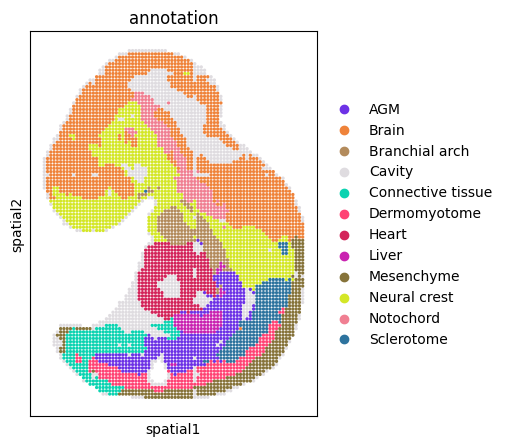

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], spot_size=1, ax =ax)

## Make spatial neighborhood graph

In [14]:
spatial_params = spatial.SpatialParams()
spatial_params = spatial_params._replace(n_rings=2)
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata,
    force_recalculate=True,
    distance_aware=True,
    spatial_params=spatial_params
)

Constructing spatial network with visium


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5913/5913 [00:00<00:00, 17883.93it/s]


## Prepare data

In [15]:
int_edges_new = int_edges_new.loc[~((int_edges_new.celltype1 == "Cavity") | (int_edges_new.celltype2 == "Cavity") )]

In [17]:
count_df = adata.to_df()

array(['Neural crest=Neural crest', 'AGM=Neural crest',
       'Neural crest=AGM', 'Sclerotome=Neural crest',
       'Neural crest=Sclerotome', 'Mesenchyme=Neural crest',
       'Neural crest=Mesenchyme', 'Branchial arch=Neural crest',
       'Neural crest=Branchial arch', 'Liver=Neural crest',
       'Neural crest=Liver', 'Heart=Neural crest', 'Neural crest=Heart',
       'Neural crest=Brain', 'Brain=Neural crest',
       'Neural crest=Notochord', 'Notochord=Neural crest'], dtype=object)

As stereoseq is near single-cell resolution we would not include self loops and call `prepare_data_list_for_other`

In [19]:
data_list_dict, umi_sums, data_list_dict_close, umi_sums_close = \
spatial.prepare_data_list_for_other(
    count_df,
    int_edges_new,
    lig_rec_info_df=geneinter_df,
    heteromeric=True,
    lig_df=ligand_df,
    rec_df=receptor_df,
    summarization='sum',
    separate_lig_rec_type=True,
    close_contact_threshold=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [01:11<00:00,  1.02it/s]


In [470]:
len(data_list_dict_close['Neural crest=Neural crest'][0][0])

1326

In [477]:
lr_pairs_ct = int_edges_new.loc[int_edges_new.interaction == 'Neural crest=Neural crest'].copy()

In [478]:
lr_pairs_ct.loc[lr_pairs_ct.distance <= 1]

cell1    cell2     celltype1     celltype2  distance boundary_type  \
3838   183_139  184_139  Neural crest  Neural crest       1.0      Internal   
3839   184_139  183_139  Neural crest  Neural crest       1.0      Internal   
3840   183_139  183_140  Neural crest  Neural crest       1.0      Internal   
3841   183_140  183_139  Neural crest  Neural crest       1.0      Internal   
3848   183_140  184_140  Neural crest  Neural crest       1.0      Internal   
...        ...      ...           ...           ...       ...           ...   
14465   229_98   228_98  Neural crest  Neural crest       1.0      Internal   
14586   229_98   229_99  Neural crest  Neural crest       1.0      Internal   
14587   229_99   229_98  Neural crest  Neural crest       1.0      Internal   
14588   229_99   230_99  Neural crest  Neural crest       1.0      Internal   
14589   230_99   229_99  Neural crest  Neural crest       1.0      Internal   

                     interaction  self_loop  
3838   Neural crest=Neural crest      False  
3839   Neural crest=Neural crest      False  
3840   Neural crest=Neural crest      False  
3841   Neural crest=Neural crest      False  
3848   Neural crest=Neural crest      False  
...                          ...        ...  
14465  Neural crest=Neural crest      False  
14586  Neural crest=Neural crest      False  
14587  Neural crest=Neural crest      False  
14588  Neural crest=Neural crest      False  
14589  Neural crest=Neural crest      False  

[1326 rows x 8 columns]

In [28]:
close_contact_index = []
other_index = []
for index,row in geneinter_df.iterrows():
    if row.annotation == 'Cell-Cell Contact':
        close_contact_index += [index]
    else:
        other_index += [index]

In [99]:
'FN1_ITGAV_ITGB1' in other_index

True

In [126]:
np.where(np.array(other_index) == 'LAMB1_SV2A')

(array([218]),)

In [105]:
len(data_list_dict['Brain=Neural crest']), len(other_index)

(1173, 1173)

In [127]:
x,y = data_list_dict['Brain=Neural crest'][218]
umi_sums_1 = umi_sums['Brain=Neural crest']['Brain']
umi_sums_2 = umi_sums['Brain=Neural crest']['Neural crest']

In [130]:
(x==0).sum()/ len(x)

0.7262872628726287

In [131]:
(y==0).sum()/ len(x)

0.9471544715447154

<Axes: >

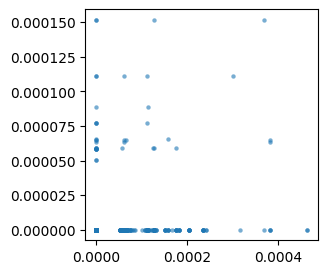

In [141]:
plt.figure(figsize=(3,3))
sns.scatterplot(x=x/umi_sums_1,y=y/umi_sums_2,s=10,linewidth=0,alpha=0.6);

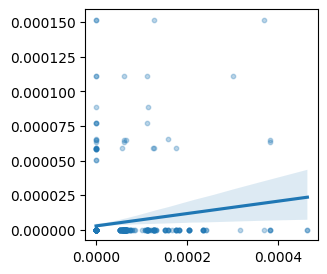

In [148]:
plt.figure(figsize=(3,3))
sns.regplot(x=x/umi_sums_1,y=y/umi_sums_2,
            scatter_kws={'s':10,'alpha':0.3});

In [149]:
x[(x!=0)&(y!=0)]

array([2, 2, 1, 1, 5, 1, 2, 2, 1, 6, 2, 2, 6, 1, 6, 1, 1])

In [152]:
y[(x!=0)&(y!=0)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [147]:
np.corrcoef(x/umi_sums_1, y/umi_sums_2)

array([[1.        , 0.15720678],
       [0.15720678, 1.        ]])

In [ ]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
opt_params = opt_params._replace(num_starts=50)
check_brain_nc = model2.run_copula(
    data_list_dict,
    umi_sums,
    df_lig_rec_index=other_,
    groups=['Brain=Neural crest'],
    n_jobs=20,
    heteronomic=True,
    use_zero_cutoff=True,
    use_length_cutoff=True,
    copula_params=copula_params,
    opt_params=opt_params
)

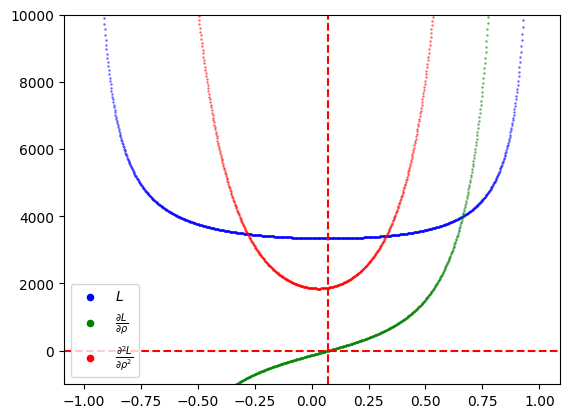

In [109]:
lig_rec_pair = 'FN1_ITGAV_ITGB1'
gpair = 'Brain=Neural crest'
likf1, d2lik, d1lik, loc_min_index = plots2.plot_liklihood_diagnostic(
    lig_rec_pair,
    gpair,
    other_index,
    close_contact_index,
    data_list_dict,
    data_list_dict_close,
    umi_sums,
    umi_sums_close,
    ymin = -1000,
    ymax = 10000
)

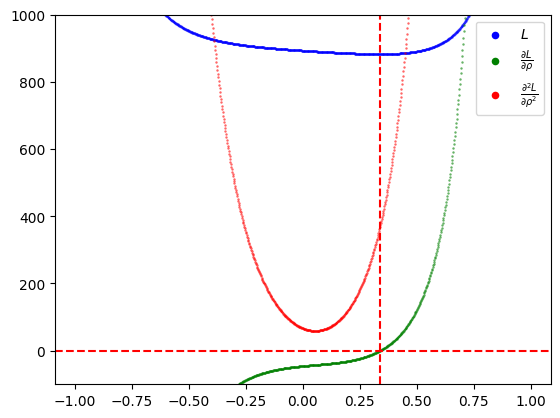

In [134]:
lig_rec_pair = 'LAMB1_SV2A'
gpair = 'Brain=Neural crest'
likf1, d2lik, d1lik, loc_min_index = plots2.plot_liklihood_diagnostic(
    lig_rec_pair,
    gpair,
    other_index,
    close_contact_index,
    data_list_dict,
    data_list_dict_close,
    umi_sums,
    umi_sums_close,
    ymin = -100,
    ymax = 1000
)

In [430]:
lig_rec_pair = 'LAMB1_SV2A'
gpair = 'Brain=Neural crest'
x, y, us1, us2 = plots2.get_data(
        lr_index,
        gpair,
        other_index,
        close_contact_index,
        data_list_dict,
        data_list_dict_close,
        umi_sums,
        umi_sums_close,
        cont_type='other'
    )

In [431]:
np.corrcoef(x/us1, y/us2)

array([[1.        , 0.15720678],
       [0.15720678, 1.        ]])

<Axes: xlabel='x', ylabel='y'>

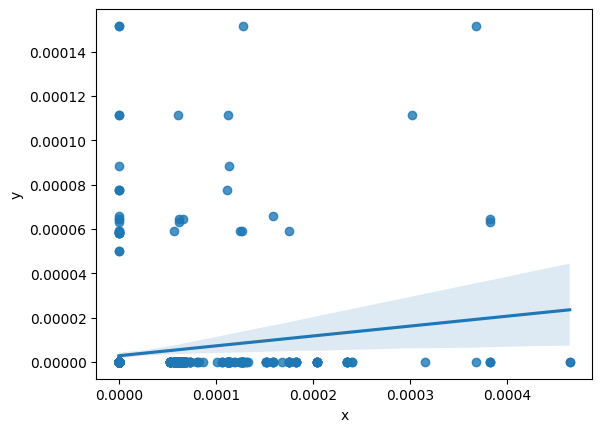

In [429]:

xy = pd.DataFrame(np.vstack([x/us1, y/us2]).T, columns=['x','y'])
sns.regplot(data=xy, x='x', y='y')

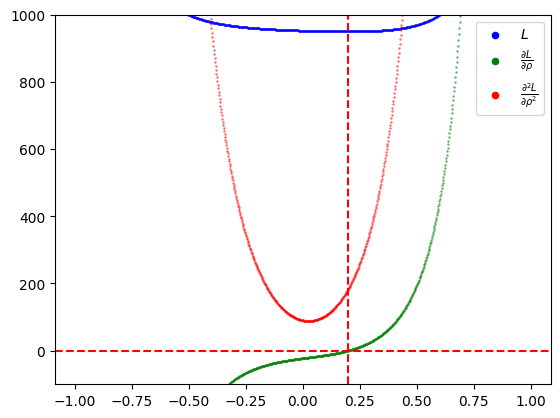

In [408]:
lig_rec_pair = 'LAMA1_SV2A'
gpair = 'Brain=Neural crest'
likf1, d2lik, d1lik, loc_min_index = plots2.plot_liklihood_diagnostic(
    lig_rec_pair,
    gpair,
    other_index,
    close_contact_index,
    data_list_dict,
    data_list_dict_close,
    umi_sums,
    umi_sums_close,
    ymin = -100,
    ymax = 1000
)

In [123]:
merged_res_dict[gpair].loc[lig_rec_pair]

copula_coeff       0.094144
mu_x              -9.023563
mu_y              -7.840211
copula_method        copula
copula_pval             0.0
copula_pval_fdr         0.0
scc                0.071401
scc_pval           0.023952
global_I             0.0071
global_pval             0.0
Name: PTN_NCL, dtype: object

In [111]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
opt_params = opt_params._replace(num_starts=50)
cop_dict_old = model2.run_copula(
    data_list_dict,
    umi_sums,
    df_lig_rec_index=other_index,
    groups=[gpair],
    n_jobs=20,
    heteronomic=True,
    use_zero_cutoff=True,
    use_length_cutoff=True,
    copula_params=copula_params,
    opt_params=opt_params
)

Brain=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   46.5s
[Parallel(n_jobs=20)]: Done 552 tasks      | elapsed:  1.6min


Number of non empty results: 161


[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:  2.5min finished


In [113]:
cop_dict_old[gpair].loc['FN1_ITGAV_ITGB1']

copula_coeff     0.072463
mu_x            -8.797008
mu_y            -8.388263
copula_method      copula
Name: FN1_ITGAV_ITGB1, dtype: object

In [125]:
cop_dict_old[gpair].loc['LAMB1_SV2A']

copula_coeff                  0.0
mu_x                   -10.365903
mu_y                   -12.551818
copula_method    skip_zero_cutoff
Name: LAMB1_SV2A, dtype: object

In [116]:
df = pd.read_csv(
    '../../orator_paper_notebook/ISMB_submission_notebooks/Mouse_embryo_stereoseq/merged_res.csv',
index_col = 0)

In [120]:
df.loc[df.interaction==gpair].loc['FN1_ITGAV_ITGB1']

copula_coeff               0.072463
mu_x                      -8.797007
mu_y                      -8.388263
copula_method                copula
interaction      Brain=Neural crest
pval                            0.0
modality                          1
gmm_modality                      1
bc                         0.372469
t_stat                    -0.302595
scc                        0.006439
scc_pval                   0.824351
global_I                  -0.212373
global_pval                     1.0
Name: FN1_ITGAV_ITGB1, dtype: object

In [48]:
focus_interactions = int_edges_new.loc[(int_edges_new.celltype1 == 'Neural crest') | 
(int_edges_new.celltype2 == 'Neural crest')].interaction.unique()

In [49]:
focus_interactions_within = []
for gpair in focus_interactions:
    if gpair.split('=')[0] == gpair.split('=')[1]:
        focus_interactions_within += [gpair]

## Load pre-existing copula results for distant indices

In [51]:
focus_interactions_within

['Neural crest=Neural crest']

In [60]:
def add_pvalue(row, bg_permutation_dict):
    if row.name in bg_permutation_dict:
        bg = bg_permutation_dict[row.name]
        if len(bg) < 100:
            return 1.0
        I = row.copula_coeff
        bg = np.append(bg, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        return pval
    return 1.0

In [53]:
len(cop_df_dict_distant)

17

In [61]:
import pickle
with open('copula_estimates.pkl', 'rb') as fp:
    copulacci_spatial_res = pickle.load(fp)
with open('copula_permutation.pkl', 'rb') as fp:
    copulacci_spatial_perm = pickle.load(fp)

In [62]:
import pickle
with open('copula_estimates_close.pkl', 'rb') as fp:
    copulacci_spatial_res_close = pickle.load(fp)
with open('copula_permutation_close.pkl', 'rb') as fp:
    copulacci_spatial_perm_close = pickle.load(fp)

## Calculate pvalues

In [63]:
from statsmodels.stats.multitest import multipletests
for ct in copulacci_spatial_res:
    copula_df = copulacci_spatial_res[ct].copy()
    copula_df['copula_pval'] = copula_df.apply(lambda row: add_pvalue(row,copulacci_spatial_perm[ct]), axis=1)
    if ct in copulacci_spatial_res_close:
        copula_df_close = copulacci_spatial_res_close[ct].copy()
        if ct in copulacci_spatial_perm_close:
            copula_df_close['copula_pval'] = copula_df_close.apply(lambda row: add_pvalue(row,copulacci_spatial_perm_close[ct]), axis=1)
        else:
            copula_df_close['copula_pval'] = 1.0
        copula_df = pd.concat([copula_df, copula_df_close])
    
    reject, pvals_corrected, _, _ = multipletests(
        copula_df.copula_pval, 
        alpha=0.05, 
        method='fdr_bh')
    copula_df['copula_pval_fdr'] = pvals_corrected
    copulacci_spatial_res[ct] = copula_df.copy()

In [66]:
copulacci_spatial_res.keys()

dict_keys(['Neural crest=Neural crest', 'AGM=Neural crest', 'Neural crest=AGM', 'Sclerotome=Neural crest', 'Neural crest=Sclerotome', 'Mesenchyme=Neural crest', 'Neural crest=Mesenchyme', 'Branchial arch=Neural crest', 'Neural crest=Branchial arch', 'Liver=Neural crest', 'Neural crest=Liver', 'Heart=Neural crest', 'Neural crest=Heart', 'Neural crest=Brain', 'Brain=Neural crest', 'Neural crest=Notochord', 'Notochord=Neural crest'])

# Spatial cross correlation runs

In [64]:
adata_scc = adata.copy()

In [67]:
scc_df_dict = model2.run_scc(
    adata_scc,
    geneinter_df,
    int_edges_new,
    groups=list(copulacci_spatial_res.keys()),
    lig_df=ligand_df,
    rec_df=receptor_df,
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

Neural crest=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   11.9s
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   27.6s
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   51.8s
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/User

AGM=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    4.0s finished


Neural crest=AGM


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    3.9s finished


Sclerotome=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    8.3s finished


Neural crest=Sclerotome


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    9.0s remaining:    0.3s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    9.2s finished


Mesenchyme=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    4.2s finished


Neural crest=Mesenchyme


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    4.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    4.2s finished


Branchial arch=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   11.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   20.8s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:   32.3s finished


Neural crest=Branchial arch


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   11.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   21.2s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:   32.4s finished


Liver=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    3.3s finished


Neural crest=Liver


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    3.4s finished


Heart=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    3.4s finished


Neural crest=Heart


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:    3.6s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:    3.7s finished


Neural crest=Brain


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   21.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   57.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:  2.7min finished


Brain=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   21.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   56.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:  2.6min finished


Neural crest=Notochord


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   16.1s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:   24.4s finished


Notochord=Neural crest


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:   15.8s
[Parallel(n_jobs=20)]: Done 1134 out of 1173 | elapsed:   23.2s remaining:    0.8s
[Parallel(n_jobs=20)]: Done 1173 out of 1173 | elapsed:   23.6s finished


In [70]:
with open('scc_estimates.pickle', 'wb') as fp:
    pickle.dump(scc_df_dict, fp)

# SpatialDM runs

In [68]:
adata_sdm = adata.copy()
adata_sdm.raw = adata_sdm.copy()
sc.pp.normalize_total(adata_sdm, target_sum=None)
sc.pp.log1p(adata_sdm)

In [72]:
sdm_df_dict = model.run_sdm(
    adata_sdm,
    int_edges_new,
    species='mouse',
    groups = list(copulacci_spatial_res.keys()),
    nproc = 20,
    heteronomic=True
)

Neural crest=Neural crest
Graph with 409 nodes and 1842 edges
(409, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Neural crest  is  38.81256604194641  seconds
AGM=Neural crest
DiGraph with 35 nodes and 48 edges
(35, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  AGM=Neural crest  is  18.636327981948853  seconds
Neural crest=AGM
DiGraph with 35 nodes and 48 edges
(35, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=AGM  is  18.50912094116211  seconds
Sclerotome=Neural crest
DiGraph with 93 nodes and 139 edges
(93, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Sclerotome=Neural crest  is  22.24653911590576  seconds
Neural crest=Sclerotome
DiGraph with 93 nodes and 139 edges
(93, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Sclerotome  is  21.627108097076416  seconds
Mesenchyme=Neural crest
DiGraph with 48 nodes and 59 edges
(48, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Mesenchyme=Neural crest  is  19.223997831344604  seconds
Neural crest=Mesenchyme
DiGraph with 48 nodes and 59 edges
(48, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Mesenchyme  is  18.810694217681885  seconds
Branchial arch=Neural crest
DiGraph with 234 nodes and 397 edges
(234, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Branchial arch=Neural crest  is  31.43171525001526  seconds
Neural crest=Branchial arch
DiGraph with 234 nodes and 397 edges
(234, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Branchial arch  is  31.471801042556763  seconds
Liver=Neural crest
DiGraph with 2 nodes and 1 edges
(2, 25568)
no effective LR found : No effective RL. Please have a check on input count matrix/species.
Neural crest=Liver
DiGraph with 2 nodes and 1 edges
(2, 25568)
no effective LR found : No effective RL. Please have a check on input count matrix/species.
Heart=Neural crest
DiGraph with 16 nodes and 18 edges
(16, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Heart=Neural crest  is  16.738434076309204  seconds
Neural crest=Heart
DiGraph with 16 nodes and 18 edges
(16, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Heart  is  17.744019985198975  seconds
Neural crest=Brain
DiGraph with 458 nodes and 738 edges
(458, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Brain  is  43.808598041534424  seconds
Brain=Neural crest
DiGraph with 458 nodes and 738 edges
(458, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Brain=Neural crest  is  44.048144817352295  seconds
Neural crest=Notochord
DiGraph with 197 nodes and 292 edges
(197, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Notochord  is  28.82173490524292  seconds
Notochord=Neural crest
DiGraph with 197 nodes and 292 edges
(197, 25568)


/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Notochord=Neural crest  is  28.032089948654175  seconds


In [73]:
with open('spatialsdm_estimates.pickle', 'wb') as fp:
    pickle.dump(sdm_df_dict, fp)

In [76]:
sdm_df_dict.keys()

dict_keys(['Neural crest=Neural crest', 'AGM=Neural crest', 'Neural crest=AGM', 'Sclerotome=Neural crest', 'Neural crest=Sclerotome', 'Mesenchyme=Neural crest', 'Neural crest=Mesenchyme', 'Branchial arch=Neural crest', 'Neural crest=Branchial arch', 'Heart=Neural crest', 'Neural crest=Heart', 'Neural crest=Brain', 'Brain=Neural crest', 'Neural crest=Notochord', 'Notochord=Neural crest'])

In [77]:
list(copulacci_spatial_res.keys())

['Neural crest=Neural crest',
 'AGM=Neural crest',
 'Neural crest=AGM',
 'Sclerotome=Neural crest',
 'Neural crest=Sclerotome',
 'Mesenchyme=Neural crest',
 'Neural crest=Mesenchyme',
 'Branchial arch=Neural crest',
 'Neural crest=Branchial arch',
 'Liver=Neural crest',
 'Neural crest=Liver',
 'Heart=Neural crest',
 'Neural crest=Heart',
 'Neural crest=Brain',
 'Brain=Neural crest',
 'Neural crest=Notochord',
 'Notochord=Neural crest']

## Merge the results

In [80]:
merged_res_dict = {}
for gpair in list(copulacci_spatial_res.keys()):
    if (
        (gpair in scc_df_dict) and 
        (gpair in sdm_df_dict) 
    ):
        tmp1 = scc_df_dict[gpair].copy()
        tmp2 = sdm_df_dict[gpair].copy()
        tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')
        res = copulacci_spatial_res[gpair]
        res = res.loc[res.copula_method == 'copula']
        res = copulacci_spatial_res[gpair].join(tmp3, how='inner')
        merged_res_dict[gpair] = res.copy()

In [81]:
merged_res_dict.keys()

dict_keys(['Neural crest=Neural crest', 'AGM=Neural crest', 'Neural crest=AGM', 'Sclerotome=Neural crest', 'Neural crest=Sclerotome', 'Mesenchyme=Neural crest', 'Neural crest=Mesenchyme', 'Branchial arch=Neural crest', 'Neural crest=Branchial arch', 'Heart=Neural crest', 'Neural crest=Heart', 'Neural crest=Brain', 'Brain=Neural crest', 'Neural crest=Notochord', 'Notochord=Neural crest'])

# Scatterplots

In [82]:
from copulacci import plots2

In [83]:
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

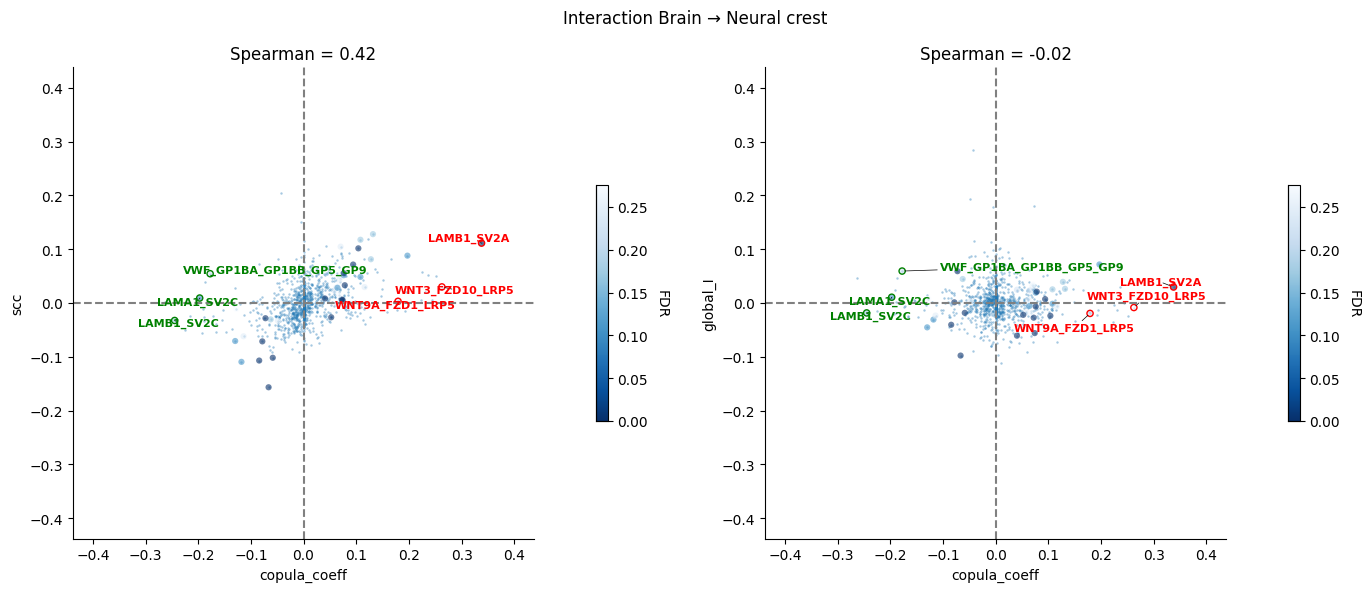

In [84]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Brain=Neural crest',
    score_pair[:2],
    ntop=3,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0.2,2),
    use_cutoff=True,
    cutoff=0.3
)

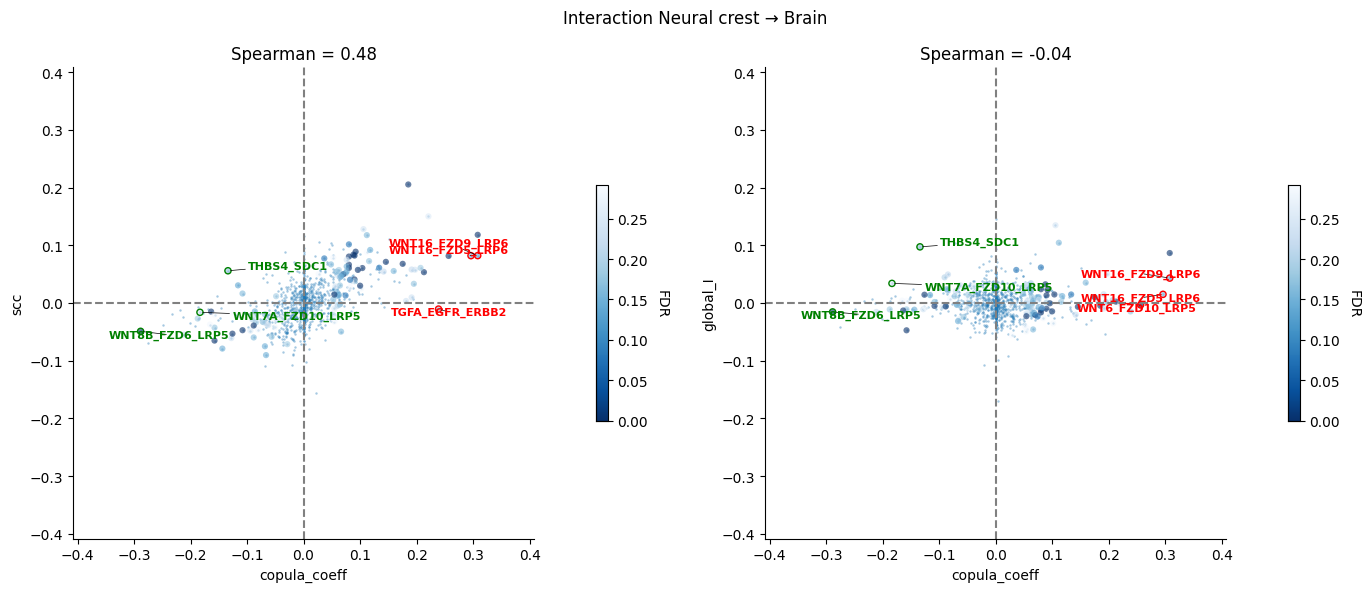

In [93]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Neural crest=Brain',
    score_pair[:2],
    ntop=3,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0.2,2),
    use_cutoff=True,
    cutoff=0.3
)

In [85]:
gpair = 'Brain=Neural crest'
res = merged_res_dict[gpair]

In [86]:
res.loc[res.copula_pval < 0.05].sort_values(['copula_coeff'],
                                            ascending=False).head(10)

copula_coeff       mu_x       mu_y copula_method  \
LAMB1_SV2A              0.337928 -10.365903 -12.551818        copula   
WNT3_FZD10_LRP5         0.262613 -13.718726  -9.973156        copula   
FGF8_FGFR3              0.250721 -11.969527 -10.654698        copula   
LAMA1_SV2A              0.197207 -10.204697 -12.551818        copula   
WNT9A_FZD1_LRP5         0.179369 -12.707126 -10.023017        copula   
SEMA3D_NRP1_PLXNA3      0.131802 -10.814561 -10.060521        copula   
WNT5A_FZD6              0.127838 -10.204697 -10.647035        copula   
SEMA3D_NRP1_PLXNA4      0.121892 -10.814561 -10.115061        copula   
WNT2_FZD10_LRP6         0.115946 -13.564576  -9.735335        copula   
ANGPTL4_SDC3            0.115946 -10.690204 -10.401249        copula   

                    copula_pval  copula_pval_fdr       scc  scc_pval  \
LAMB1_SV2A             0.000000         0.000000  0.111238  0.001996   
WNT3_FZD10_LRP5        0.010101         0.275546  0.029844  0.281437   
FGF8_FGFR3             0.018072         0.385433  0.050655  0.113772   
LAMA1_SV2A             0.001996         0.111491  0.087931  0.001996   
WNT9A_FZD1_LRP5        0.005988         0.226579  0.003055  0.920160   
SEMA3D_NRP1_PLXNA3     0.003992         0.173778  0.127909  0.001996   
WNT5A_FZD6             0.003992         0.173778  0.081267  0.007984   
SEMA3D_NRP1_PLXNA4     0.015968         0.350358  0.118065  0.001996   
WNT2_FZD10_LRP6        0.026000         0.417781 -0.039837  0.177645   
ANGPTL4_SDC3           0.007984         0.246454  0.029490  0.259481   

                    global_I    global_pval  
LAMB1_SV2A          0.029621  2.883447e-150  
WNT3_FZD10_LRP5    -0.008496   1.000000e+00  
FGF8_FGFR3         -0.023700   1.000000e+00  
LAMA1_SV2A          0.071568   0.000000e+00  
WNT9A_FZD1_LRP5    -0.019401   1.000000e+00  
SEMA3D_NRP1_PLXNA3  0.026187  8.135477e-118  
WNT5A_FZD6          0.039184  1.228093e-261  
SEMA3D_NRP1_PLXNA4  0.018985   1.065744e-62  
WNT2_FZD10_LRP6    -0.072564   1.000000e+00  
ANGPTL4_SDC3       -0.006473   1.000000e+00

In [92]:
gpair = 'Neural crest=Brain'
res = merged_res_dict[gpair]
res.head()

copula_coeff       mu_x      mu_y copula_method  \
COL6A4_ITGA9_ITGB1     -0.012883 -14.423620 -8.556802        copula   
COL4A3_ITGA9_ITGB1      0.012883 -13.817484 -8.556802        copula   
COL6A3_ITGA9_ITGB1      0.012883 -11.938713 -8.556802        copula   
COL6A1_ITGA9_ITGB1      0.064414 -11.808660 -8.556802        copula   
COL4A4_ITGA9_ITGB1      0.008919 -14.018155 -8.556802        copula   

                    copula_pval  copula_pval_fdr       scc  scc_pval  \
COL6A4_ITGA9_ITGB1     0.236948         0.864486  0.035970  0.205589   
COL4A3_ITGA9_ITGB1     0.175258         0.761397  0.021203  0.423154   
COL6A3_ITGA9_ITGB1     0.550898         1.000000 -0.024431  0.443114   
COL6A1_ITGA9_ITGB1     0.003992         0.134057  0.044888  0.113772   
COL4A4_ITGA9_ITGB1     0.497006         1.000000  0.002914  0.912176   

                    global_I  global_pval  
COL6A4_ITGA9_ITGB1  0.055352          0.0  
COL4A3_ITGA9_ITGB1 -0.010766          1.0  
COL6A3_ITGA9_ITGB1 -0.038840          1.0  
COL6A1_ITGA9_ITGB1 -0.020187          1.0  
COL4A4_ITGA9_ITGB1 -0.000540          1.0

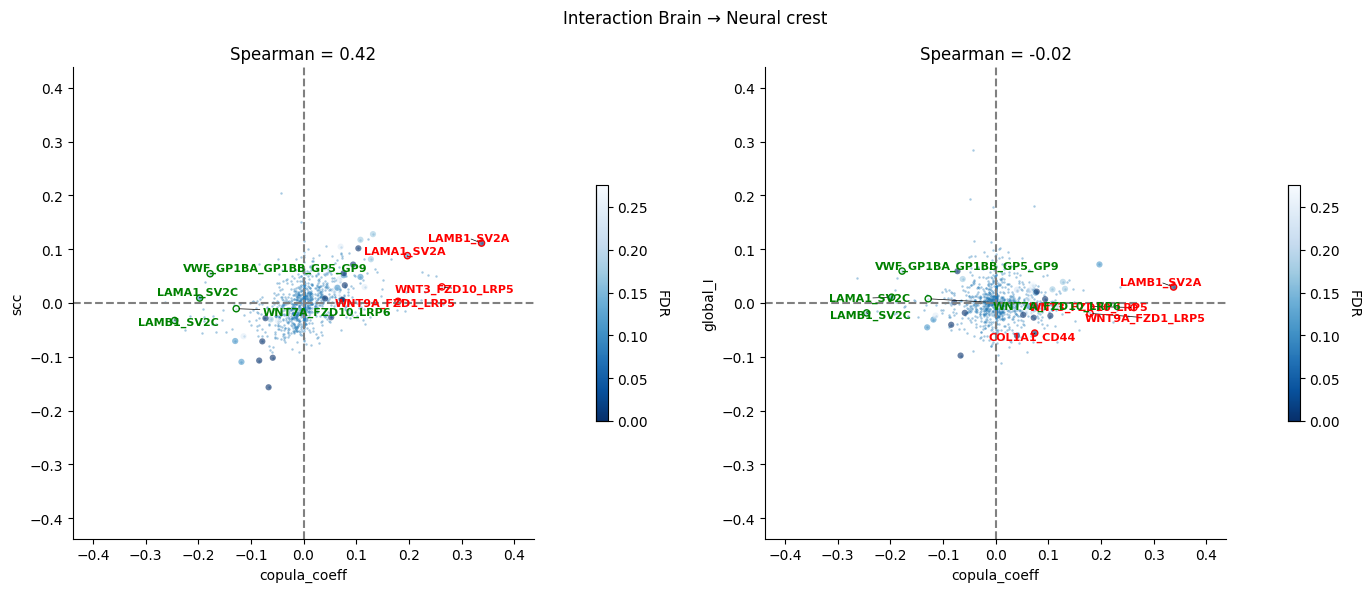

In [89]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    gpair,
    score_pair[:2],
    ntop=4,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0,1),
    use_cutoff=True,
    cutoff=0.3
)

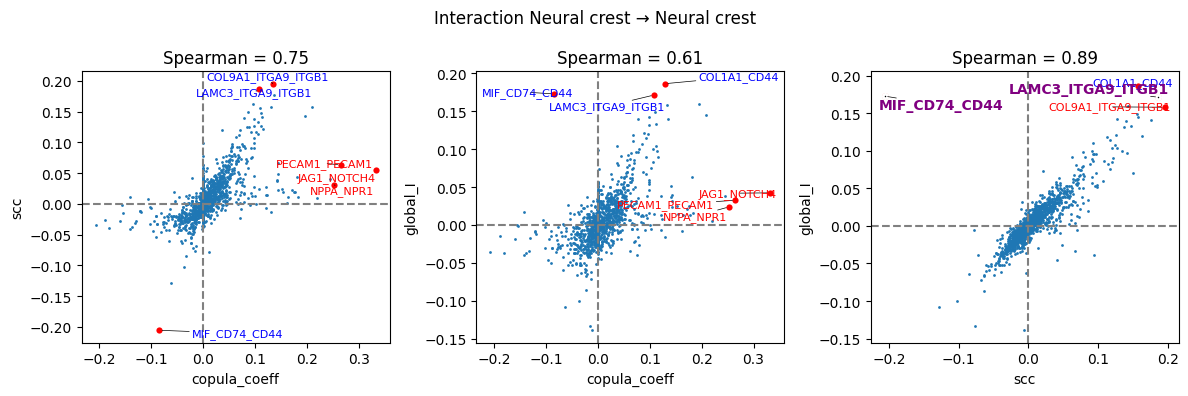

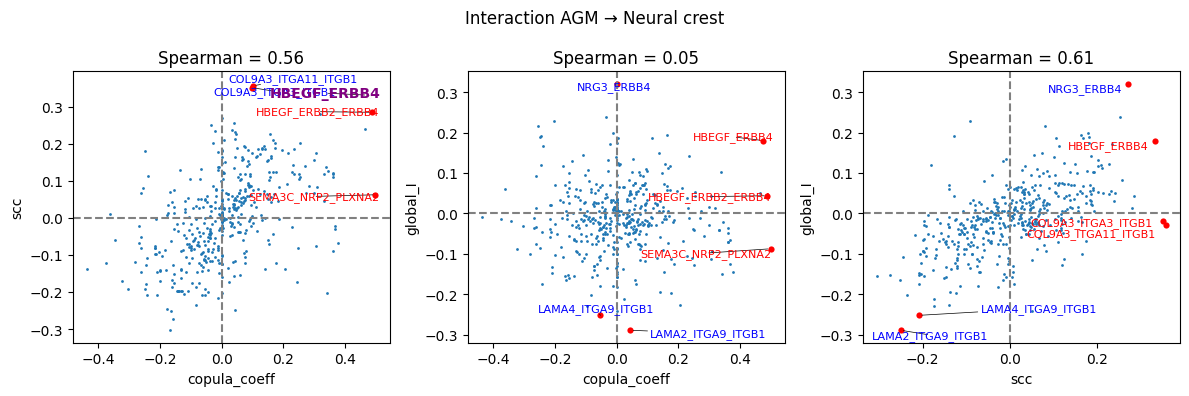

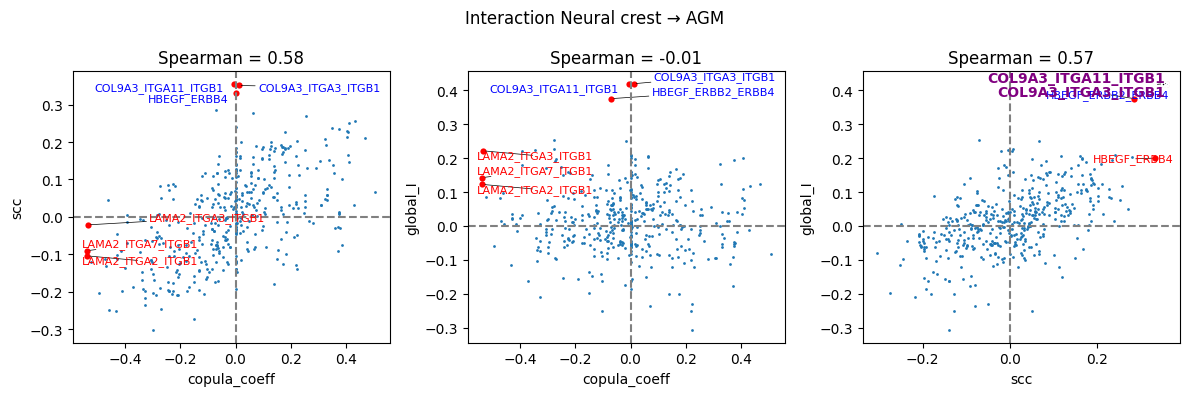

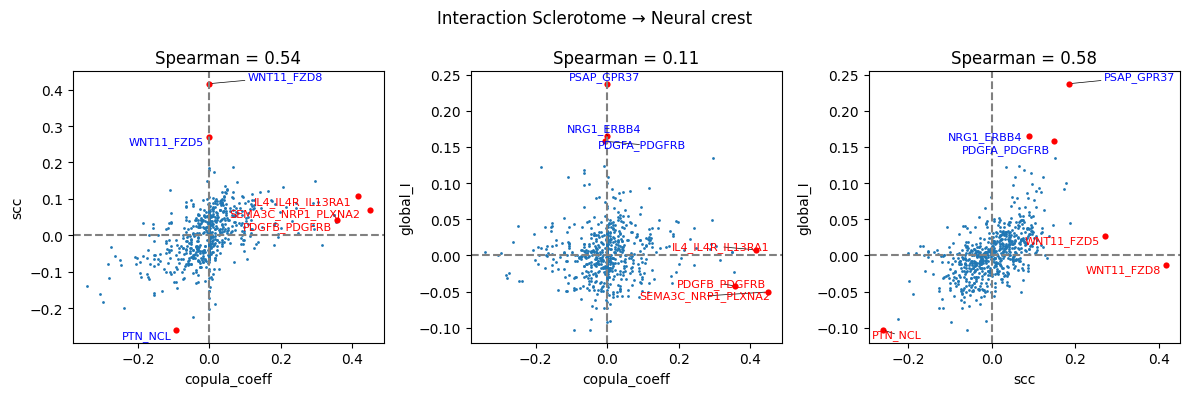

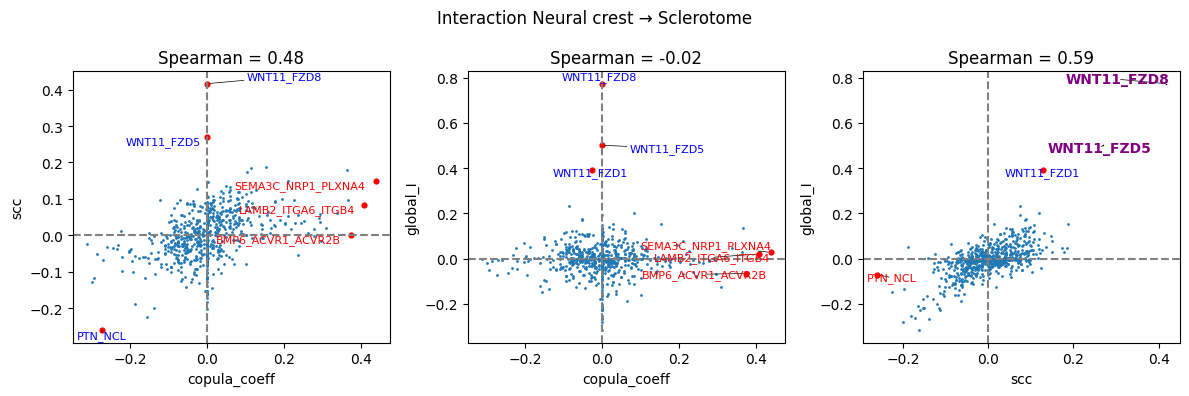

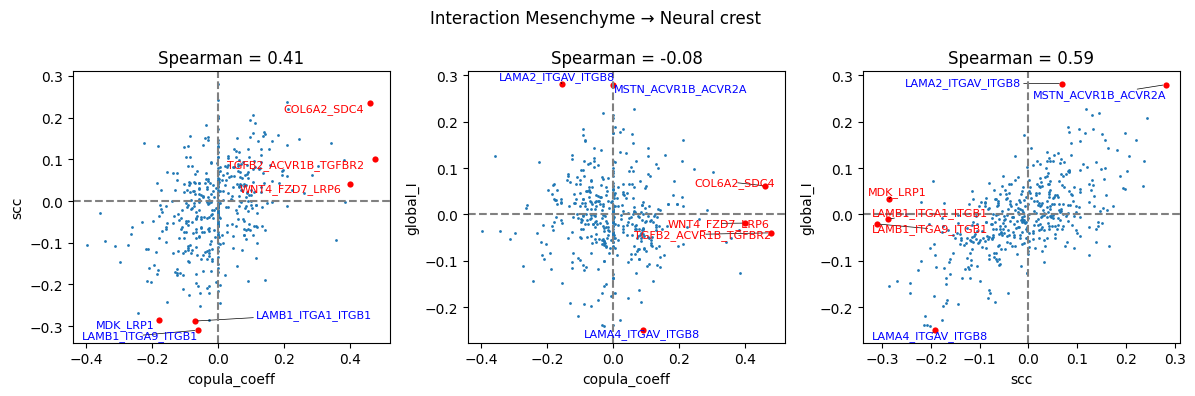

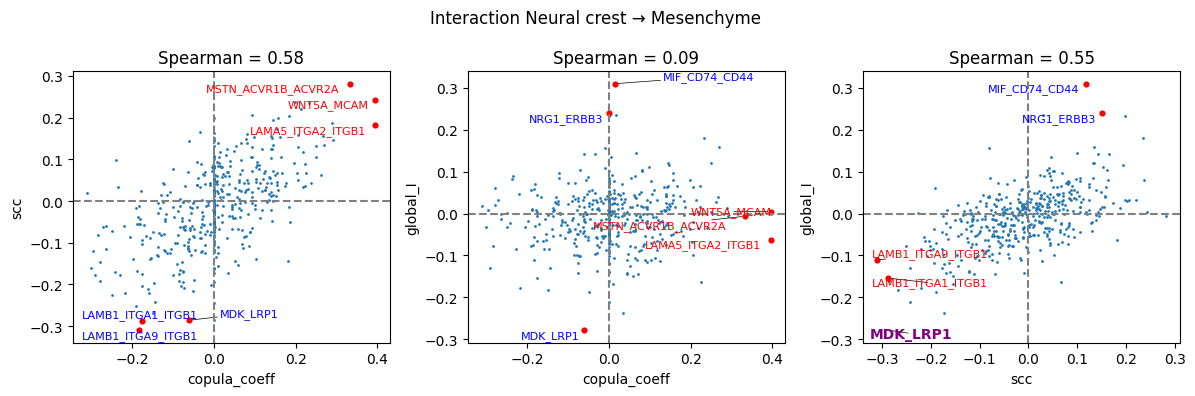

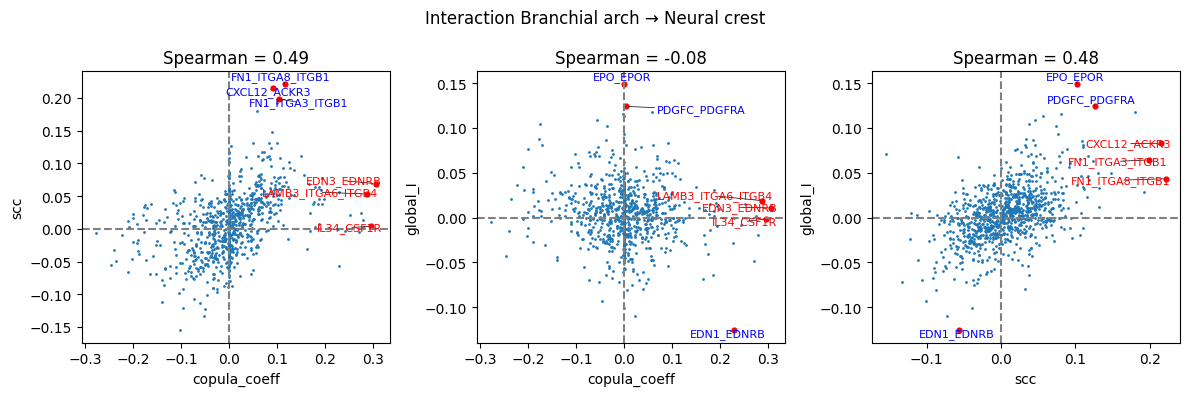

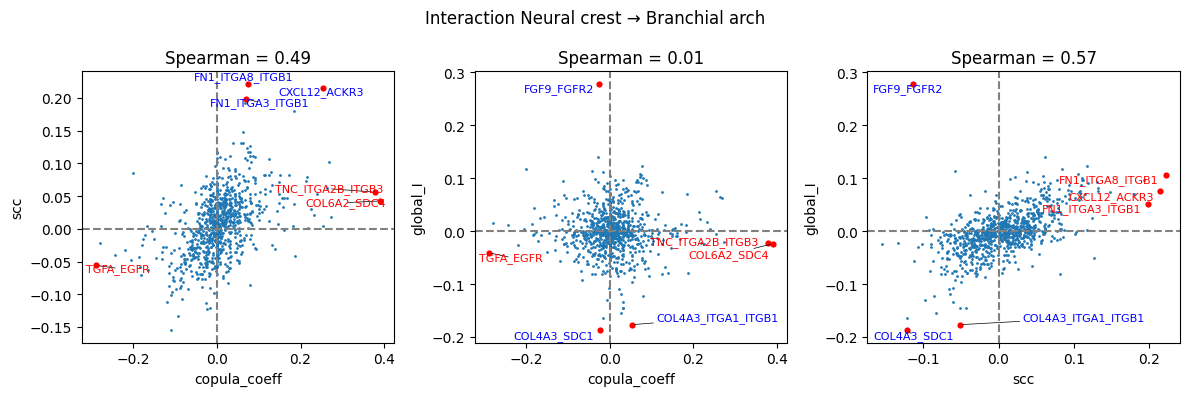

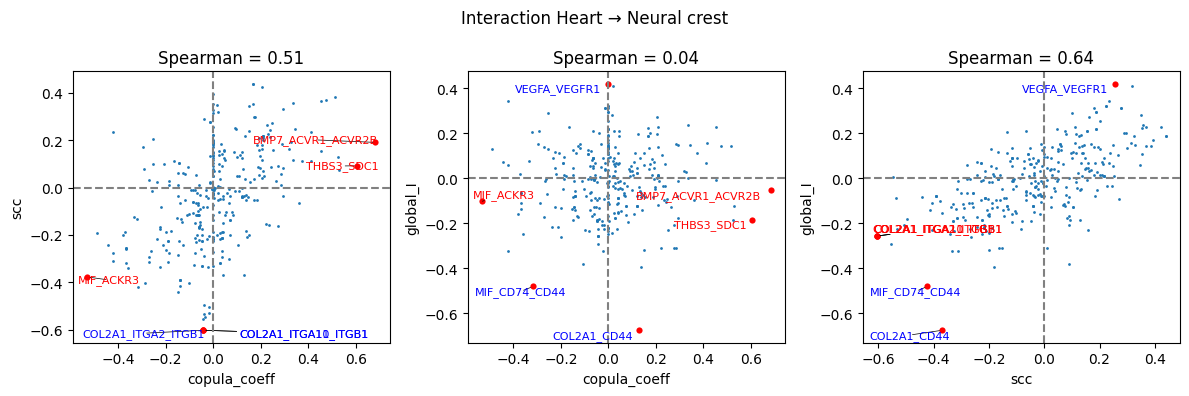

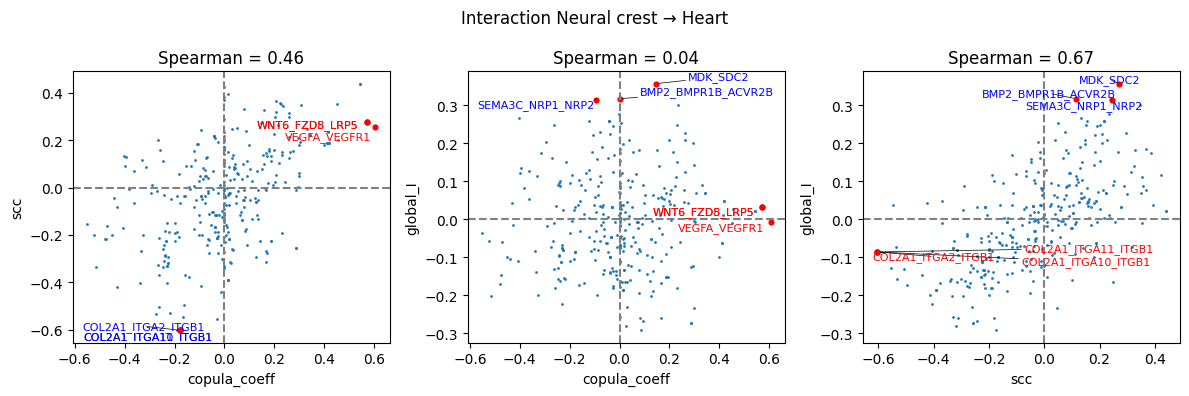

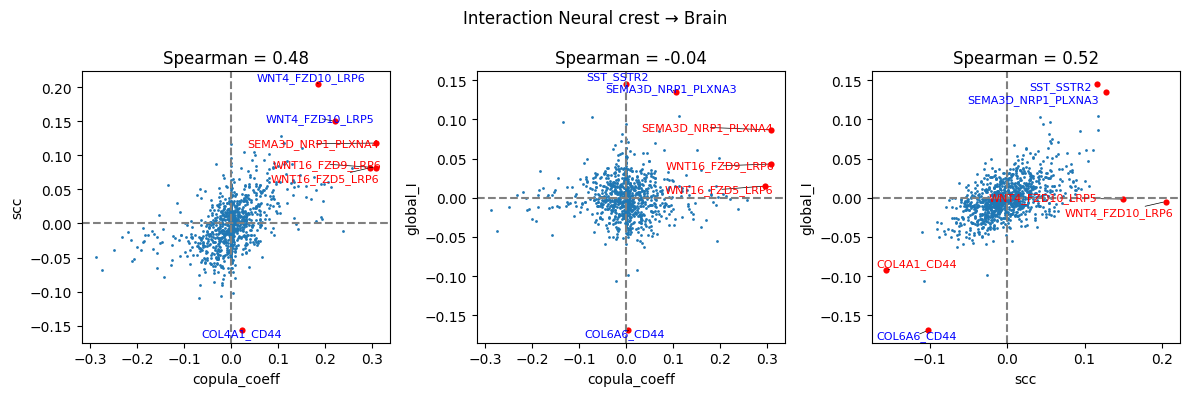

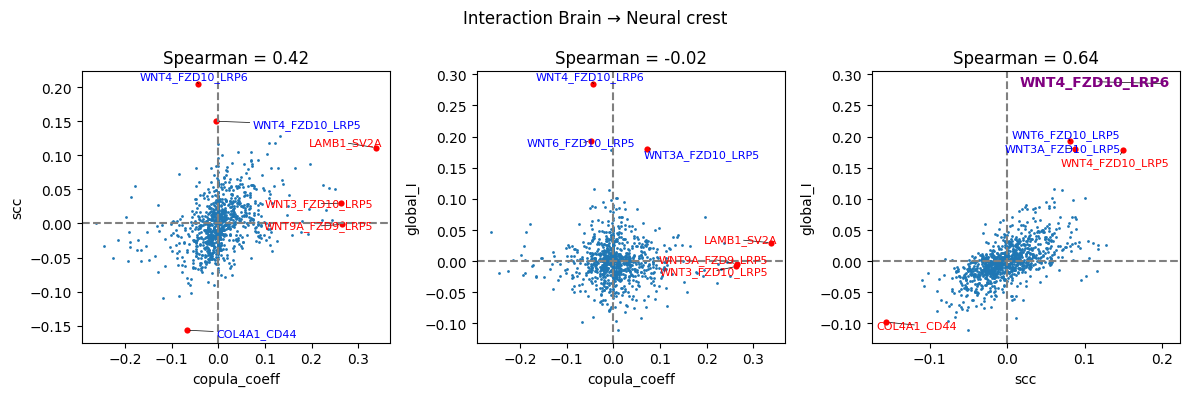

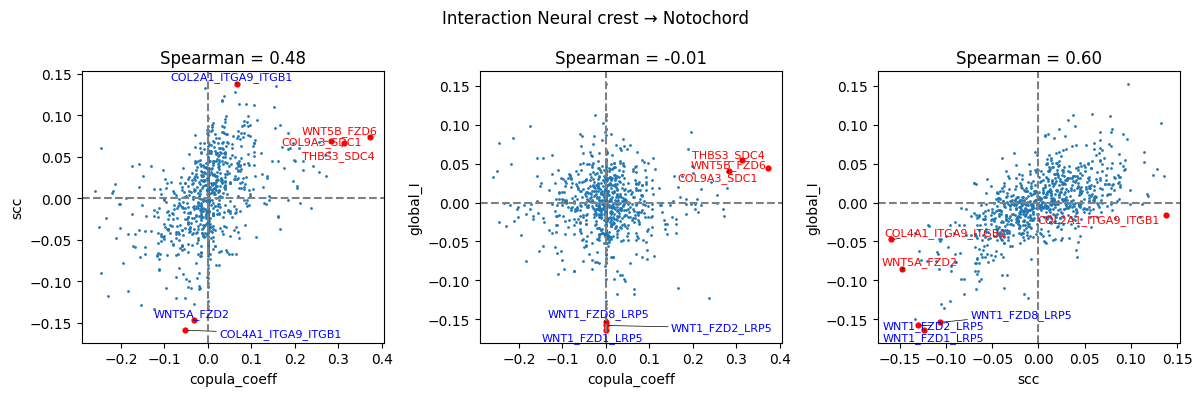

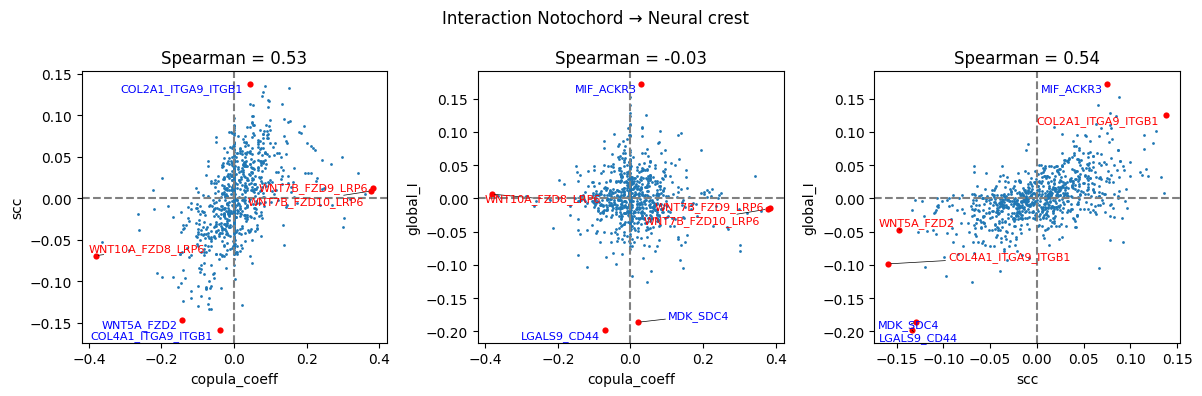

In [95]:
for gpair in merged_res_dict:
    plots2.draw_pairwise_scatter(merged_res_dict,
                          gpair,
                          score_pair,
                          bimod_filter=False,
                        s = 4,
                        ntop=3,
                        #only_pos=True
                         )

In [96]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df

In [97]:
copulacci_merged_df = linearize_to_df(merged_res_dict)

In [98]:
copulacci_merged_df.to_csv('copulacci_with_other_results.csv', index=False)

In [266]:
lr_index = 'LAMB1_SV2A'
gpair = 'Brain=Neural crest'

array([2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 5, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

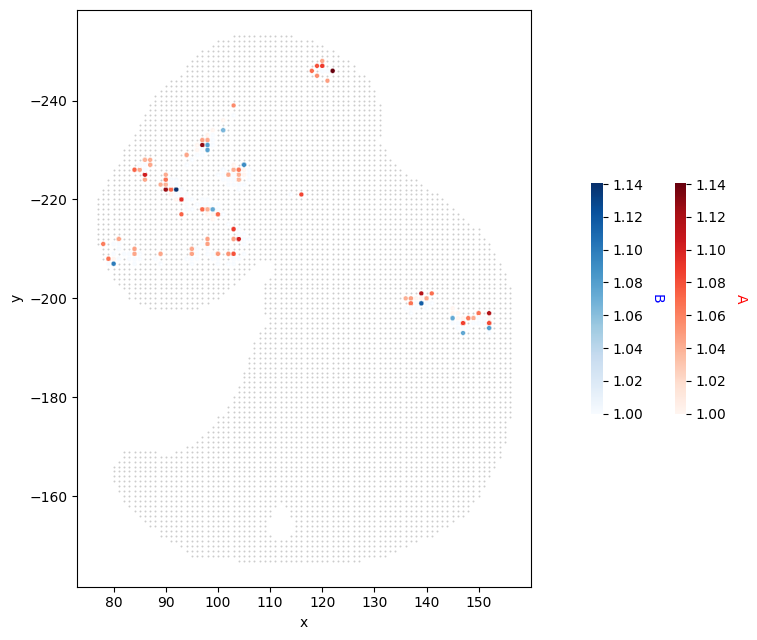

In [388]:
lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == gpair,
            :
    ].copy()

fig, ax = plt.subplots(1, 1, figsize=(8,6.5))
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=2, linewidth=0,alpha = 0.4)

lig_gene_vec = np.array(adata_plot.to_df().loc[lr_pairs_ct.cell1, 'Lamb1'].values)
rec_gene_vec = np.array(adata_plot.to_df().loc[lr_pairs_ct.cell2, 'Sv2a'].values)

lr_pairs_ct['A'] = lig_gene_vec
lr_pairs_ct['B'] = rec_gene_vec
lr_pairs_ct_nz = lr_pairs_ct.loc[lr_pairs_ct[['A','B']].sum(1) > 0].copy()
global_min = min(lig_gene_vec.min(), rec_gene_vec.min())
global_max = min(lig_gene_vec.max(), rec_gene_vec.max())

sns.scatterplot(x='x', y='y',
    palette='Reds',s=12, data=loc_df.loc[lr_pairs_ct_nz.cell1,:],
    hue = lr_pairs_ct_nz['A'].values,
    #edgecolor='black',
    alpha=1.0,
    ax= ax
)
norm = Normalize(1, global_max)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.get_legend().remove()
cax = ax.figure.colorbar(sm,ax=ax,shrink=0.4, pad=-0.01)
cax.outline.set_visible(False)
cax.set_label('A', color='red', rotation=270, labelpad=15)

sns.scatterplot(x='x', y='y',
    palette='Blues',s=12, data=loc_df.loc[lr_pairs_ct_nz.cell2,:],
    hue = lr_pairs_ct_nz['B'].values,
    #edgecolor='black',
    alpha=1.0,
    ax= ax
)
ax.get_legend().remove()
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm,ax=ax,shrink=0.4, pad=0.1)
cax.outline.set_visible(False)
cax.set_label('B', color='blue', rotation=270, labelpad=15)

# ax.axhline(-195,ls='--',c='r')
# ax.axhline(-240,ls='--',c='r')
# ax.axvline(75,ls='--',c='r')
# ax.axvline(115,ls='--',c='r')
# ax.set_xlim(75, 100)
# ax.set_ylim(-240, -195)
ax.invert_yaxis()
plt.tight_layout()

In [ ]:
lr_pairs_ct.loc[lr_pairs_ct[['A','B']].sum(1) > 0]

In [374]:
lr_pairs_ct[['A','B']].sum()

A    343
B     39
dtype: int64

In [352]:
loc_df_restriced = loc_df.loc[((loc_df.x <= 100) & (loc_df.x >= 75)) & ((loc_df.y <= -195) & (loc_df.y >= -240))].copy()

In [360]:
cell1 = list(set(loc_df_restriced.index).intersection(lr_pairs_ct.cell1))
cell2 = list(set(loc_df_restriced.index).intersection(lr_pairs_ct.cell2))

In [363]:
vec1 = np.array(count_df.loc[cell1, 'Lamb1'].values)

In [364]:
vec2 = np.array(count_df.loc[cell2, 'Sv2a'].values)

In [484]:
from matplotlib.colors import Normalize
def plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1,
    gene2,
    count_df,
    merged_res,
    shrink_fraction=1.0,
    file_name = None,
    no_edges = False,
    figure_parent = ".",
    figsize = (7,5),
    markersize = 10,
    cont_type = 'other',
    copula_params=model2.CopulaParams(),
    threshold_distance = 1
):
    
    int_type = gpair
    lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == int_type,
            :
    ].copy()
    if cont_type != 'other':
        lr_pairs_ct = lr_pairs_ct.loc[lr_pairs_ct.distance <= threshold_distance]
        

    tmp = loc_df
    tmp = tmp.loc[
        list(set(lr_pairs_ct.cell1).union(lr_pairs_ct.cell2).intersection(tmp.index)),
        :
    ]

    x, y, us1, us2 = plots2.get_data(
        lr_index,
        gpair,
        other_index,
        close_contact_index,
        data_list_dict,
        data_list_dict_close,
        umi_sums,
        umi_sums_close,
        cont_type=cont_type
    )
    copula_params = copula_params._replace(return_sum=False)
    sx = np.log(x.sum() / us1.sum())
    sy = np.log(y.sum() / us2.sum())

    if isinstance(merged_res, pd.DataFrame):
        res = merged_res.copy()
    else:
        res = merged_data_dict[gpair].copy()
    
    coeff = res.loc[lr_index].copula_coeff
    loglikvec = model2.calculate_mahalanobis_distance(
        [coeff, sx, sy],
        x,
        y,
        us1,
        us2,
        copula_params
    )
    lr_pairs_ct['copula_score'] = loglikvec
    lr_pairs_ct[gene1] = count_df.loc[lr_pairs_ct.cell1, gene1].values
    lr_pairs_ct[gene2] = count_df.loc[lr_pairs_ct.cell2, gene2].values
    
    selected_cells_1 = list(set(lr_pairs_ct.cell1).intersection(set(tmp.index)))
    selected_cells_2 = list(set(lr_pairs_ct.cell2).intersection(set(tmp.index)))

    max_gene1 = count_df.loc[selected_cells_1, gene1].values.max()
    max_gene2 = count_df.loc[selected_cells_2, gene2].values.max()
    global_max = max(max_gene1, max_gene2)
    global_min = min(
        count_df.loc[selected_cells_1, gene1].values.min(),
        count_df.loc[selected_cells_2, gene2].values.min()
    )

    
    fig, ax = plt.subplots(1, 1, figsize=figsize,dpi=500)
    
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=1, linewidth=0,alpha = 0.4)
    colors = np.array(count_df.loc[selected_cells_1, gene1].values)
    tmp = loc_df.loc[selected_cells_1,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',
                    palette='Reds',s=markersize, data=tmp,
                    #edgecolor='black',
                    alpha=1.0,
                    ax= ax)
    # sns.scatterplot(x='x', y='y', hue='gene',
    #                          palette='Reds',s=15, 
    #                     data=tmp,alpha=0.7,ax= ax[i])
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    # norm = Normalize(
    #     vmin=tmp['gene'].min(), 
    #     vmax=np.quantile(tmp['gene'].values,0.6)
    # )
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=-0.01)
    cax.outline.set_visible(False)
    cax.set_label(gene1, color='red', rotation=270, labelpad=15)
    
    colors = np.array(count_df.loc[selected_cells_2, gene2].values)
    tmp = loc_df.loc[selected_cells_2,:].copy()
    tmp.loc[:, 'gene'] = colors
    # sns.scatterplot(x='x', y='y', hue='gene',marker="^",
    #                  palette='Blues',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    sns.scatterplot(x='x', y='y', hue='gene',
                    palette='Blues',s=markersize, data=tmp,
                    #edgecolor='black',
                    alpha=1.0,
                    ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    # norm = Normalize(
    #     vmin=tmp['gene'].min(), 
    #     vmax=np.quantile(tmp['gene'].values,0.6)
    # )
    # norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.set_title(f"{lr_index} - copula: {coeff:.2f} \n {gpair}")
    #ax.set_title(gene1 + " | " + gene2 + "\n" + gpair)
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction, pad=-0.01)
    cax.outline.set_visible(False)
    cax.set_label(gene2, color='blue', rotation=270, labelpad=15)


    # draw edges
    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score, 0.9))
    cmap = plt.get_cmap('Greys')
    #lr_pairs_ct = lr_pairs_ct.loc[lr_pairs_ct.copula_score >= 0.2]

    def add_curved_arrow(p1, p2, curvature, color):
        arrow = FancyArrowPatch(p1, p2, connectionstyle=f"arc3,rad={curvature}", 
                                 arrowstyle='->', color=color,
                                 mutation_scale=10.0, 
                                 lw=1, clip_on=False)
        plt.gca().add_patch(arrow)

    lr_pairs_ct = lr_pairs_ct.loc[lr_pairs_ct.copula_score >= 0.2]
    lr_pairs_ct_nz = lr_pairs_ct.loc[lr_pairs_ct[[gene1, gene2]].sum(1) > 0].copy()
    if no_edges:
        for ind,row in lr_pairs_ct_nz.iterrows():
            if row.distance > 1.0:
                continue
            x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
            x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
            dx = x2 - x1
            dy = y2 - y1
            color = cmap(norm(row.copula_score))
            # ax.plot([x1, x2], [y1, y2], color='black',
            #         linestyle='-', markersize=0.5,linewidth=0.3)
            
            ax.quiver(np.array([x1]), np.array([y1]), 
                  np.array([dx]), np.array([dy]),
                  angles='xy', scale_units='xy',
                  color=color,
                  scale=1, 
                  headwidth=5,
                  headaxislength=2.5,
                  headlength=5,
                  width=0.002,
            )
        
        
    
        
        # ax.arrow(x1, y1, dx, dy, head_width=0.05, 
        #          head_length=0.1, fc='k', ec='k')
    # for ind,row in loglik_df_filt.iterrows():
    #     color = cmap(norm(row.copula_score))
    #     x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
    #     x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
    #     ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
    #             linestyle='-', markersize=0.5,linewidth=1)

    # norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
    #                  vmax=np.quantile(lr_pairs_ct.copula_score,0.9))
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=0.01)
    cax.outline.set_visible(False)
    cax.set_label('mhl', color='blue', rotation=270, labelpad=15)
    
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.set_xlim(70, 102)
    # ax.set_ylim(-242, -195)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    plt.show()
    return(lr_pairs_ct)

In [155]:
count_df_norm = count_df.div(count_df.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

loc_df = plots2.get_loc_df(adata)

In [156]:
figure_parent = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'

In [254]:
adata_plot = adata.copy()
sc.pp.normalize_total(adata_plot, target_sum=None)
sc.pp.log1p(adata_plot)
#sc.pp.scale(adata_plot)

In [221]:
adata_plot.to_df()

gene_short_name  1700007G11Rik  1700123O20Rik  1810030O07Rik  2010107E04Rik  \
cell_name                                                                     
147_104               3.143921       3.778373       3.672366       1.359640   
147_105               0.355331      -0.721645      -0.516733       1.554756   
147_106               0.774201      -0.721645      -0.516733       1.307146   
147_107               0.989674      -0.721645      -0.516733      -0.919466   
147_108               0.563334      -0.721645      -0.516733      -0.111902   
...                        ...            ...            ...            ...   
253_110              -0.075340       3.212352      -0.516733       1.596988   
253_111              -1.243373      -0.721645      -0.516733      -1.312049   
253_112              -0.857274      -0.721645      -0.516733      -0.963009   
253_113              -0.864938      -0.721645      -0.516733      -4.011541   
253_114              -4.229479      -0.721645      -0.516733      -4.011541   

gene_short_name  2210016F16Rik  2600014E21Rik  2610001J05Rik  2810429I04Rik  \
cell_name                                                                     
147_104               4.241273       2.299381       2.836490       7.099844   
147_105              -0.475138       1.167396      -0.694022      -0.358300   
147_106              -0.475138      -1.887685      -0.694022      -0.358300   
147_107              -0.475138      -1.887685      -0.694022      -0.358300   
147_108              -0.475138       0.429628      -0.694022      -0.358300   
...                        ...            ...            ...            ...   
253_110              -0.475138      -1.887685      -0.694022      -0.358300   
253_111              -0.475138       0.743514      -0.694022      -0.358300   
253_112              -0.475138      -1.887685      -0.694022      -0.358300   
253_113              -0.475138      -1.887685      -0.694022      -0.358300   
253_114              -0.475138       6.181719      -0.694022      -0.358300   

gene_short_name  3830406C13Rik  4930481A15Rik  ...  Vmn1r202     Psg18  \
cell_name                                      ...                       
147_104              10.583993       0.769085  ... -0.013005 -0.013005   
147_105              -0.247546       0.642924  ... -0.013005 -0.013005   
147_106              -0.247546       0.448409  ... -0.013005 -0.013005   
147_107              -0.247546       0.604887  ... -0.013005 -0.013005   
147_108              -0.247546      -2.175556  ... -0.013005 -0.013005   
...                        ...            ...  ...       ...       ...   
253_110              -0.247546      -0.146357  ... -0.013005 -0.013005   
253_111              -0.247546      -2.175556  ... -0.013005 -0.013005   
253_112              -0.247546      -2.175556  ... -0.013005 -0.013005   
253_113              -0.247546       0.559501  ... -0.013005 -0.013005   
253_114              -0.247546      -2.175556  ... -0.013005 -0.013005   

gene_short_name   Gm36737      Smcp   Gm14288   Gm32089  Trav13n-1   Gm48436  \
cell_name                                                                      
147_104         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
147_105         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
147_106         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
147_107         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
147_108         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
...                   ...       ...       ...       ...        ...       ...   
253_110         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
253_111         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
253_112         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
253_113         -0.013005 -0.013005 -0.013005 -0.013005  -0.013005 -0.013005   
253_114         -0.01

In [225]:
gpair = 'Brain=Neural crest'
lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == gpair,
        :
].copy()

In [237]:
dist = ( 
    (loc_df.loc[lr_pairs_ct.cell1].x.values - loc_df.loc[lr_pairs_ct.cell2].x.values)**2 + \
    (loc_df.loc[lr_pairs_ct.cell1].y.values - loc_df.loc[lr_pairs_ct.cell2].y.values)**2
)

In [464]:
int_edges_new.loc[int_edges_new.interaction == gpair]

cell1    cell2     celltype1     celltype2  distance boundary_type  \
3832   183_139  183_141  Neural crest  Neural crest       2.0      Internal   
3833   183_141  183_139  Neural crest  Neural crest       2.0      Internal   
3834   183_139  184_140  Neural crest  Neural crest       2.0      Internal   
3835   184_140  183_139  Neural crest  Neural crest       2.0      Internal   
3836   183_139  185_139  Neural crest  Neural crest       2.0      Internal   
...        ...      ...           ...           ...       ...           ...   
14589   230_99   229_99  Neural crest  Neural crest       1.0      Internal   
14590  230_106  231_105  Neural crest  Neural crest       2.0      Internal   
14591  231_105  230_106  Neural crest  Neural crest       2.0      Internal   
15250  234_102  235_103  Neural crest  Neural crest       2.0      Internal   
15251  235_103  234_102  Neural crest  Neural crest       2.0      Internal   

                     interaction  self_loop  
3832   Neural crest=Neural crest      False  
3833   Neural crest=Neural crest      False  
3834   Neural crest=Neural crest      False  
3835   Neural crest=Neural crest      False  
3836   Neural crest=Neural crest      False  
...                          ...        ...  
14589  Neural crest=Neural crest      False  
14590  Neural crest=Neural crest      False  
14591  Neural crest=Neural crest      False  
15250  Neural crest=Neural crest      False  
15251  Neural crest=Neural crest      False  

[3684 rows x 8 columns]

In [466]:
int_edges_with_selfloop.loc[(int_edges_with_selfloop.interaction == gpair) & int_edges_with_selfloop.self_loop]

cell1    cell2     celltype1     celltype2  distance boundary_type  \
33517  180_141  180_141  Neural crest  Neural crest       0.0      Internal   
33567  181_138  181_138  Neural crest  Neural crest       0.0      Internal   
33568  181_139  181_139  Neural crest  Neural crest       0.0      Internal   
33569  181_140  181_140  Neural crest  Neural crest       0.0      Internal   
33570  181_141  181_141  Neural crest  Neural crest       0.0      Internal   
...        ...      ...           ...           ...       ...           ...   
36865  237_103  237_103  Neural crest  Neural crest       0.0      Internal   
36866  237_104  237_104  Neural crest  Neural crest       0.0      Internal   
36867  237_105  237_105  Neural crest  Neural crest       0.0      Internal   
37261  246_120  246_120  Neural crest  Neural crest       0.0      Internal   
37262  246_121  246_121  Neural crest  Neural crest       0.0      Internal   

                     interaction  self_loop  
33517  Neural crest=Neural crest       True  
33567  Neural crest=Neural crest       True  
33568  Neural crest=Neural crest       True  
33569  Neural crest=Neural crest       True  
33570  Neural crest=Neural crest       True  
...                          ...        ...  
36865  Neural crest=Neural crest       True  
36866  Neural crest=Neural crest       True  
36867  Neural crest=Neural crest       True  
37261  Neural crest=Neural crest       True  
37262  Neural crest=Neural crest       True  

[1008 rows x 8 columns]

In [498]:
'JAG1_NOTCH4' in close_contact_index

True

In [495]:
# lr_index = 'L1CAM_ITGA4_ITGB7'
# gpair = 'Neural crest=Neural crest'
# loglik_df = lr_interaction_boundary_likelihood(gpair, lr_index,
#             filt=False,part=False,cont_type='close',norm=False,exp=False,mhl=True,
#             shrink_fraction=0.4,
# #            file_name='BRCA_il6_cd4_tumor_mhl_score.pdf'
# )

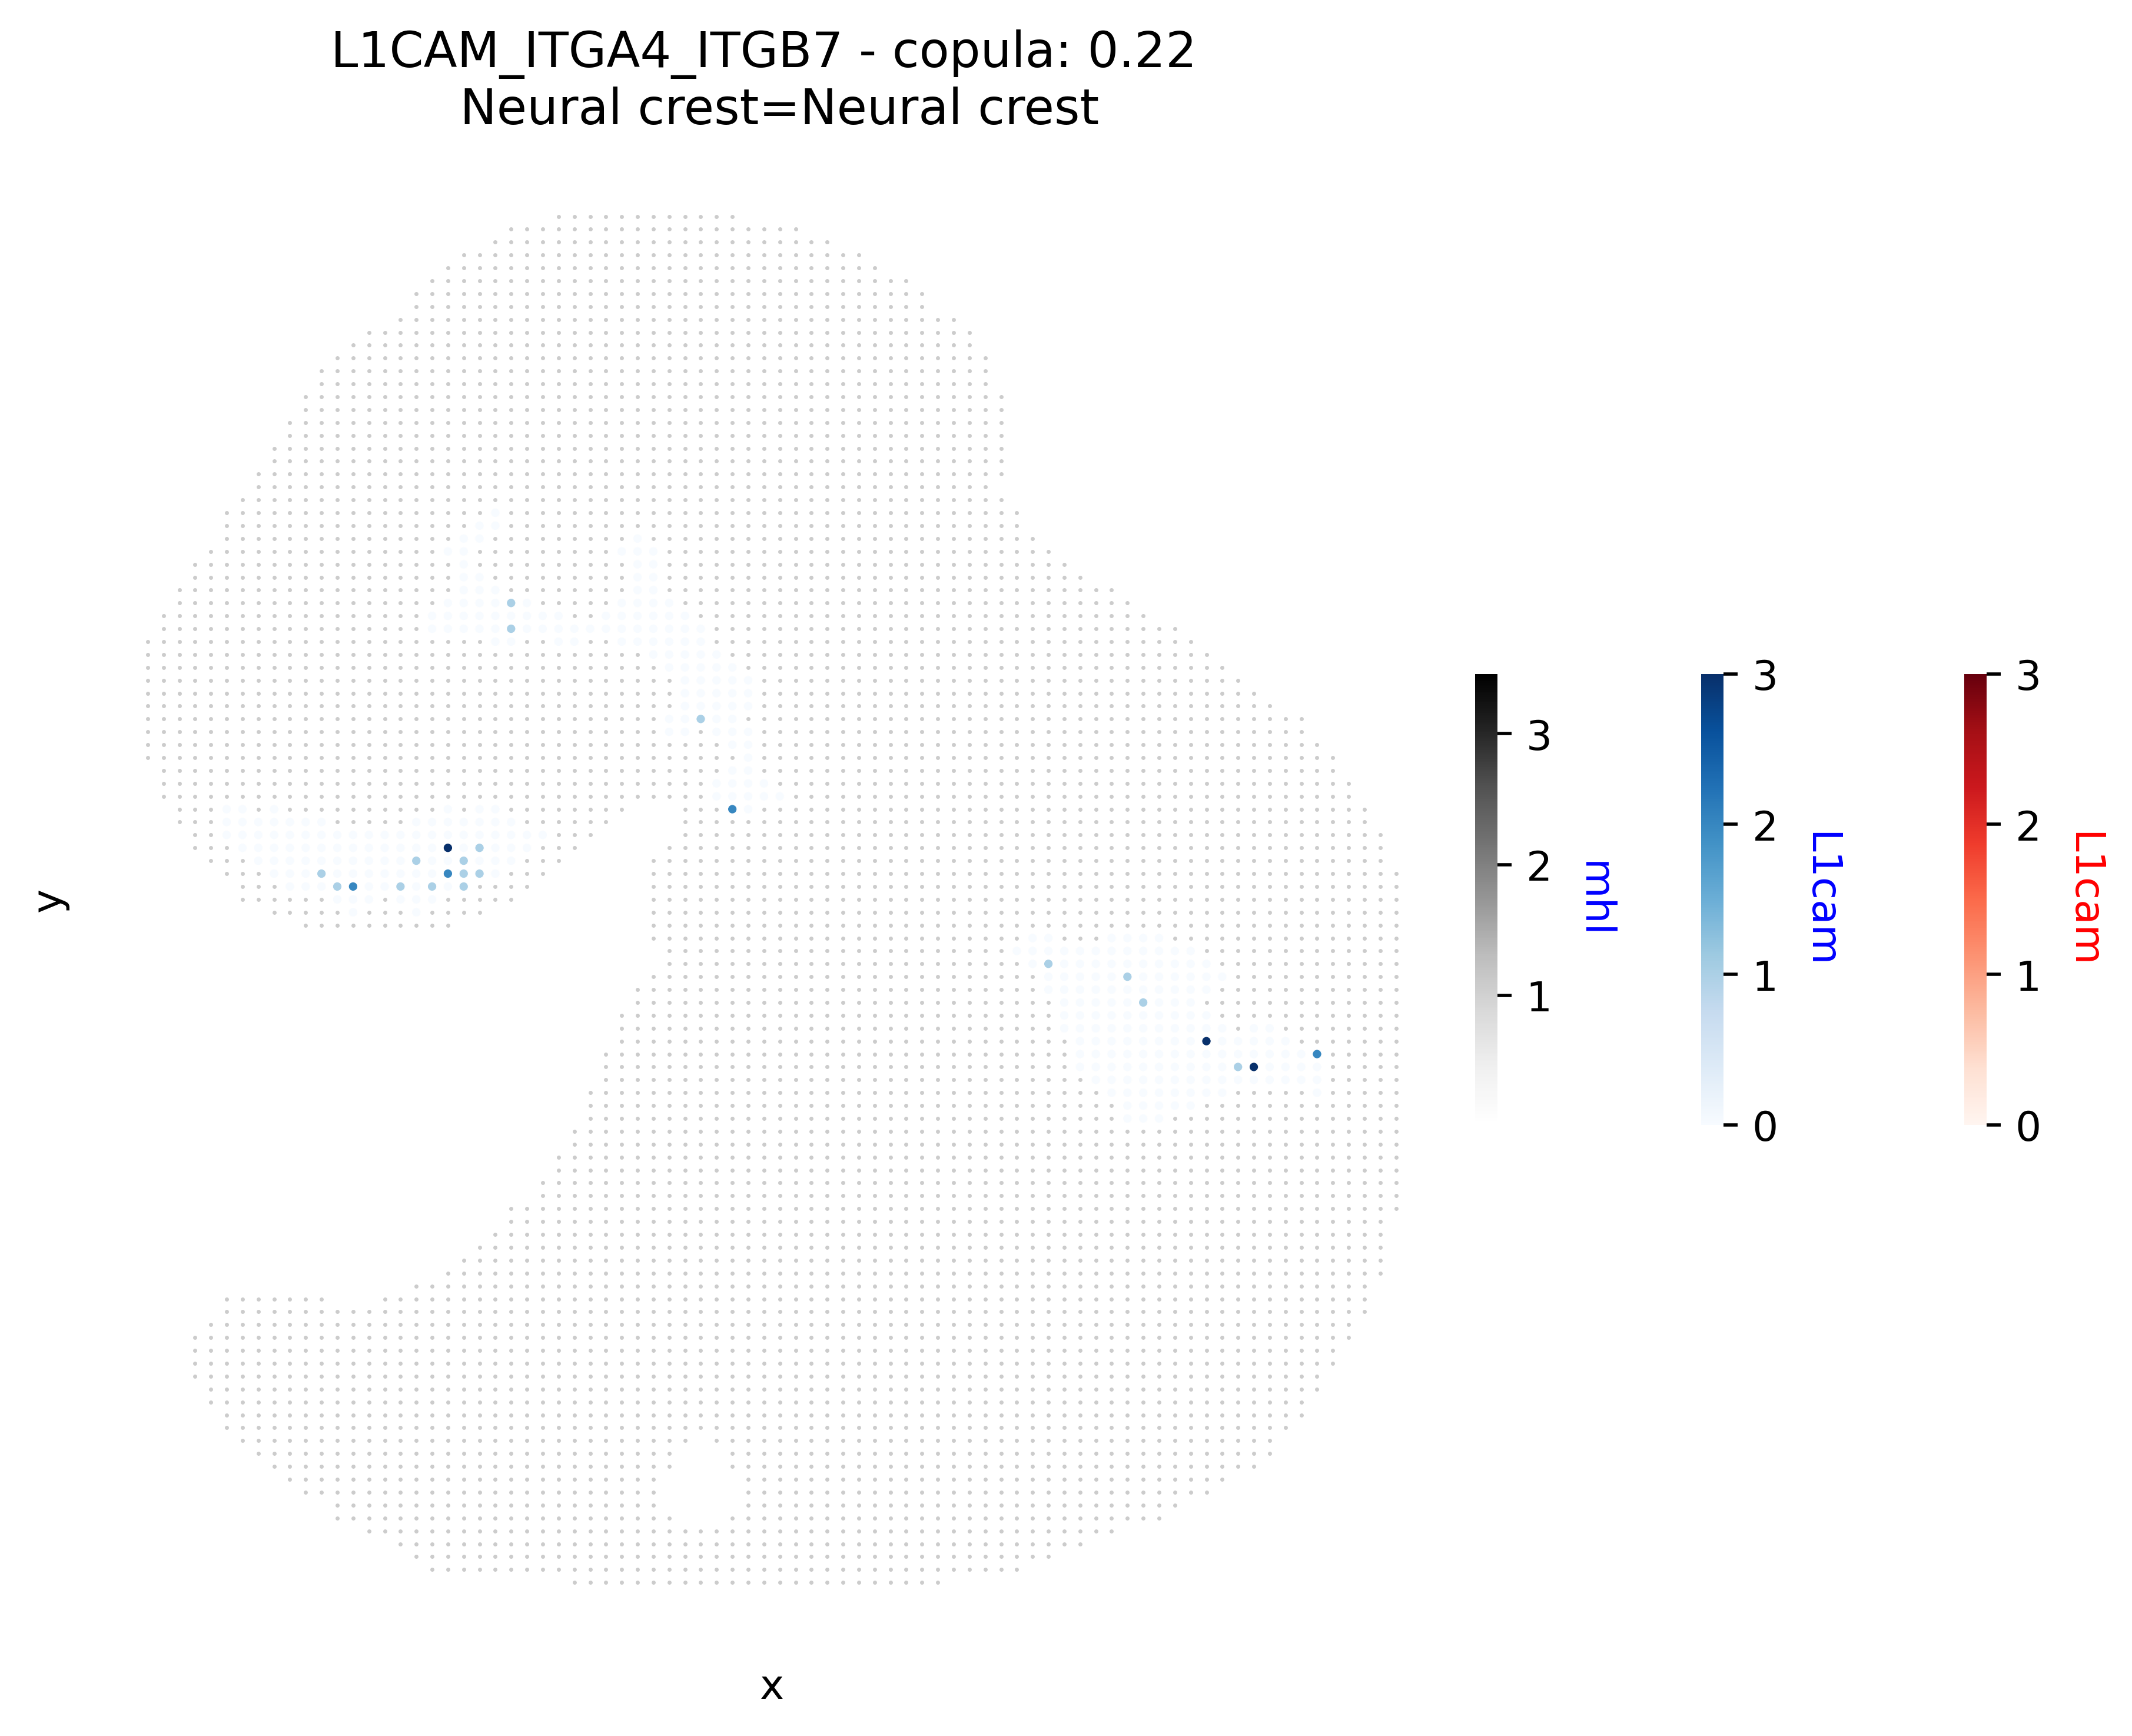

In [497]:
lr_index = 'L1CAM_ITGA4_ITGB7'
gpair = 'Neural crest=Neural crest'
lr_pairs_ct = plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='L1cam',
    gene2='L1cam',
    count_df = adata.to_df(),
    merged_res=merged_res_dict[gpair],
    shrink_fraction=0.3,
    markersize=5,
    figsize=(8,6),
    cont_type='close',
    figure_parent = figure_parent,
    no_edges = False,
    #file_name='MOSTA_{}_two_color.pdf'.format(lr_index)
)

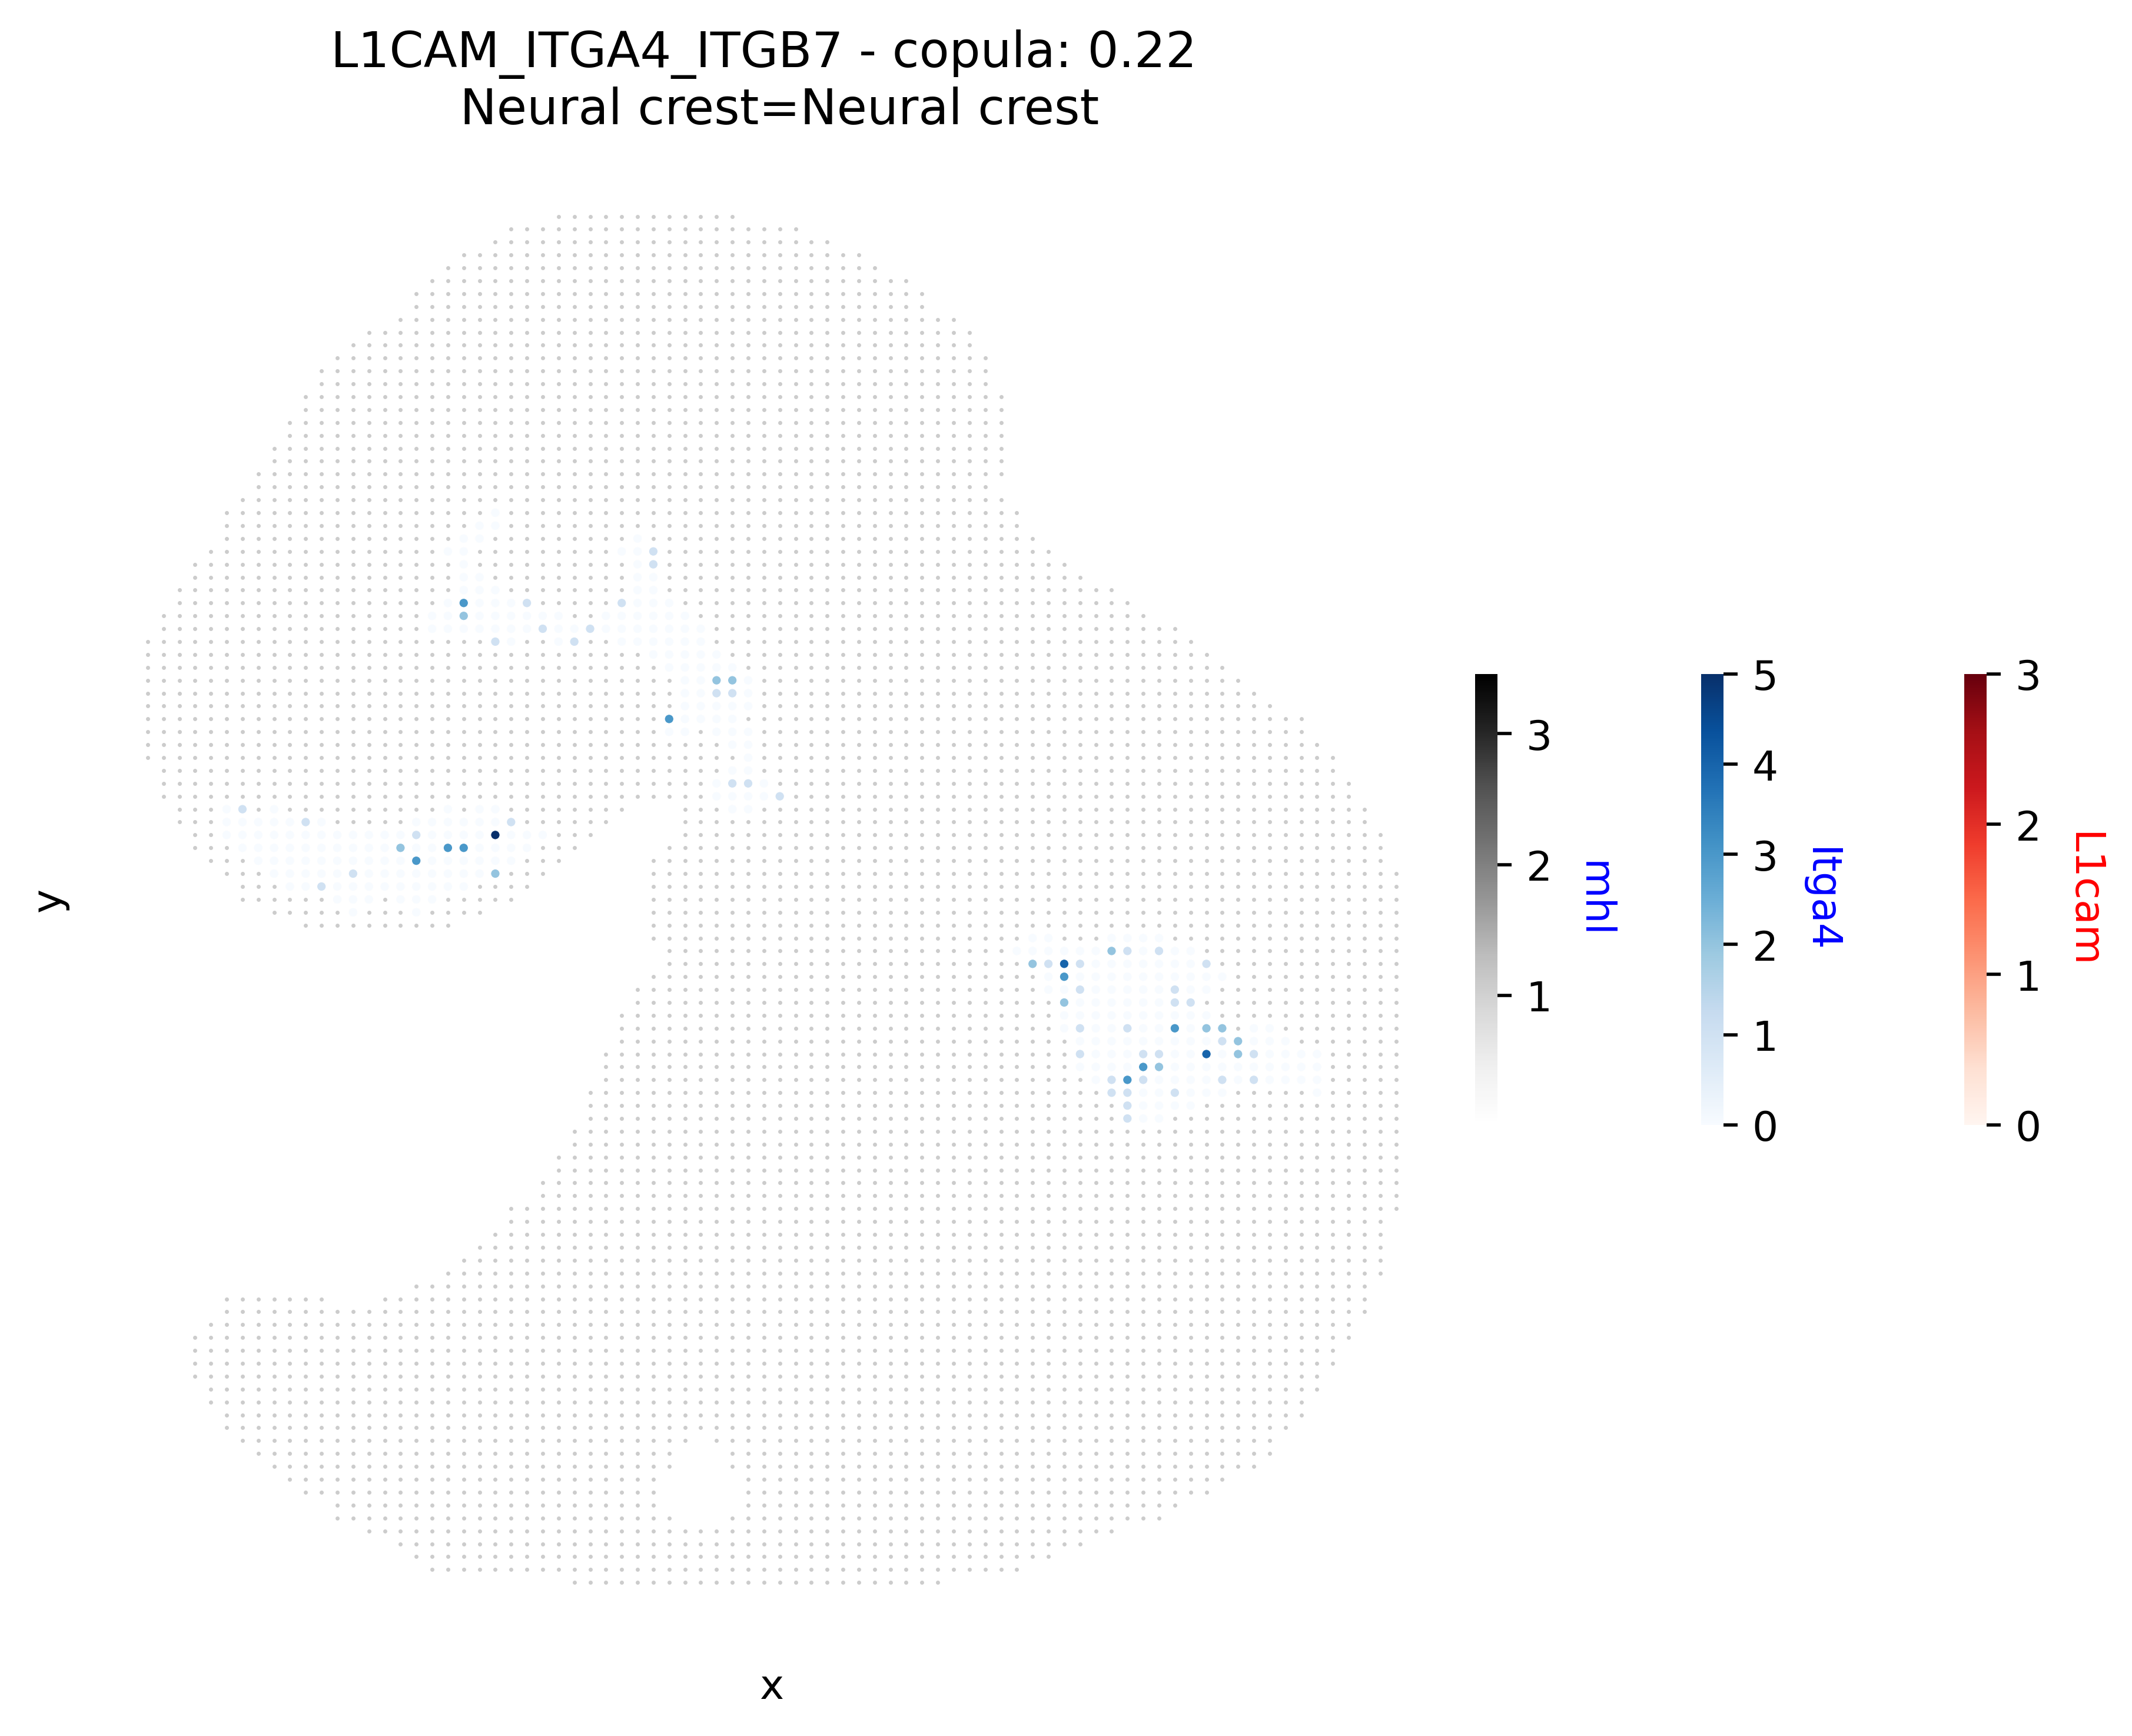

In [496]:
lr_index = 'L1CAM_ITGA4_ITGB7'
gpair = 'Neural crest=Neural crest'
lr_pairs_ct = plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='L1cam',
    gene2='Itga4',
    count_df = adata.to_df(),
    merged_res=merged_res_dict[gpair],
    shrink_fraction=0.3,
    markersize=5,
    figsize=(8,6),
    cont_type='close',
    figure_parent = figure_parent,
    no_edges = False,
    #file_name='MOSTA_{}_two_color.pdf'.format(lr_index)
)

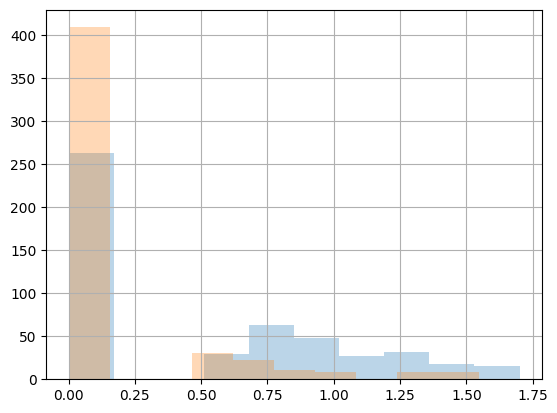

In [492]:
lr_pairs_ct.Itga4.hist(alpha=0.3)
lr_pairs_ct.L1cam.hist(alpha=0.3);

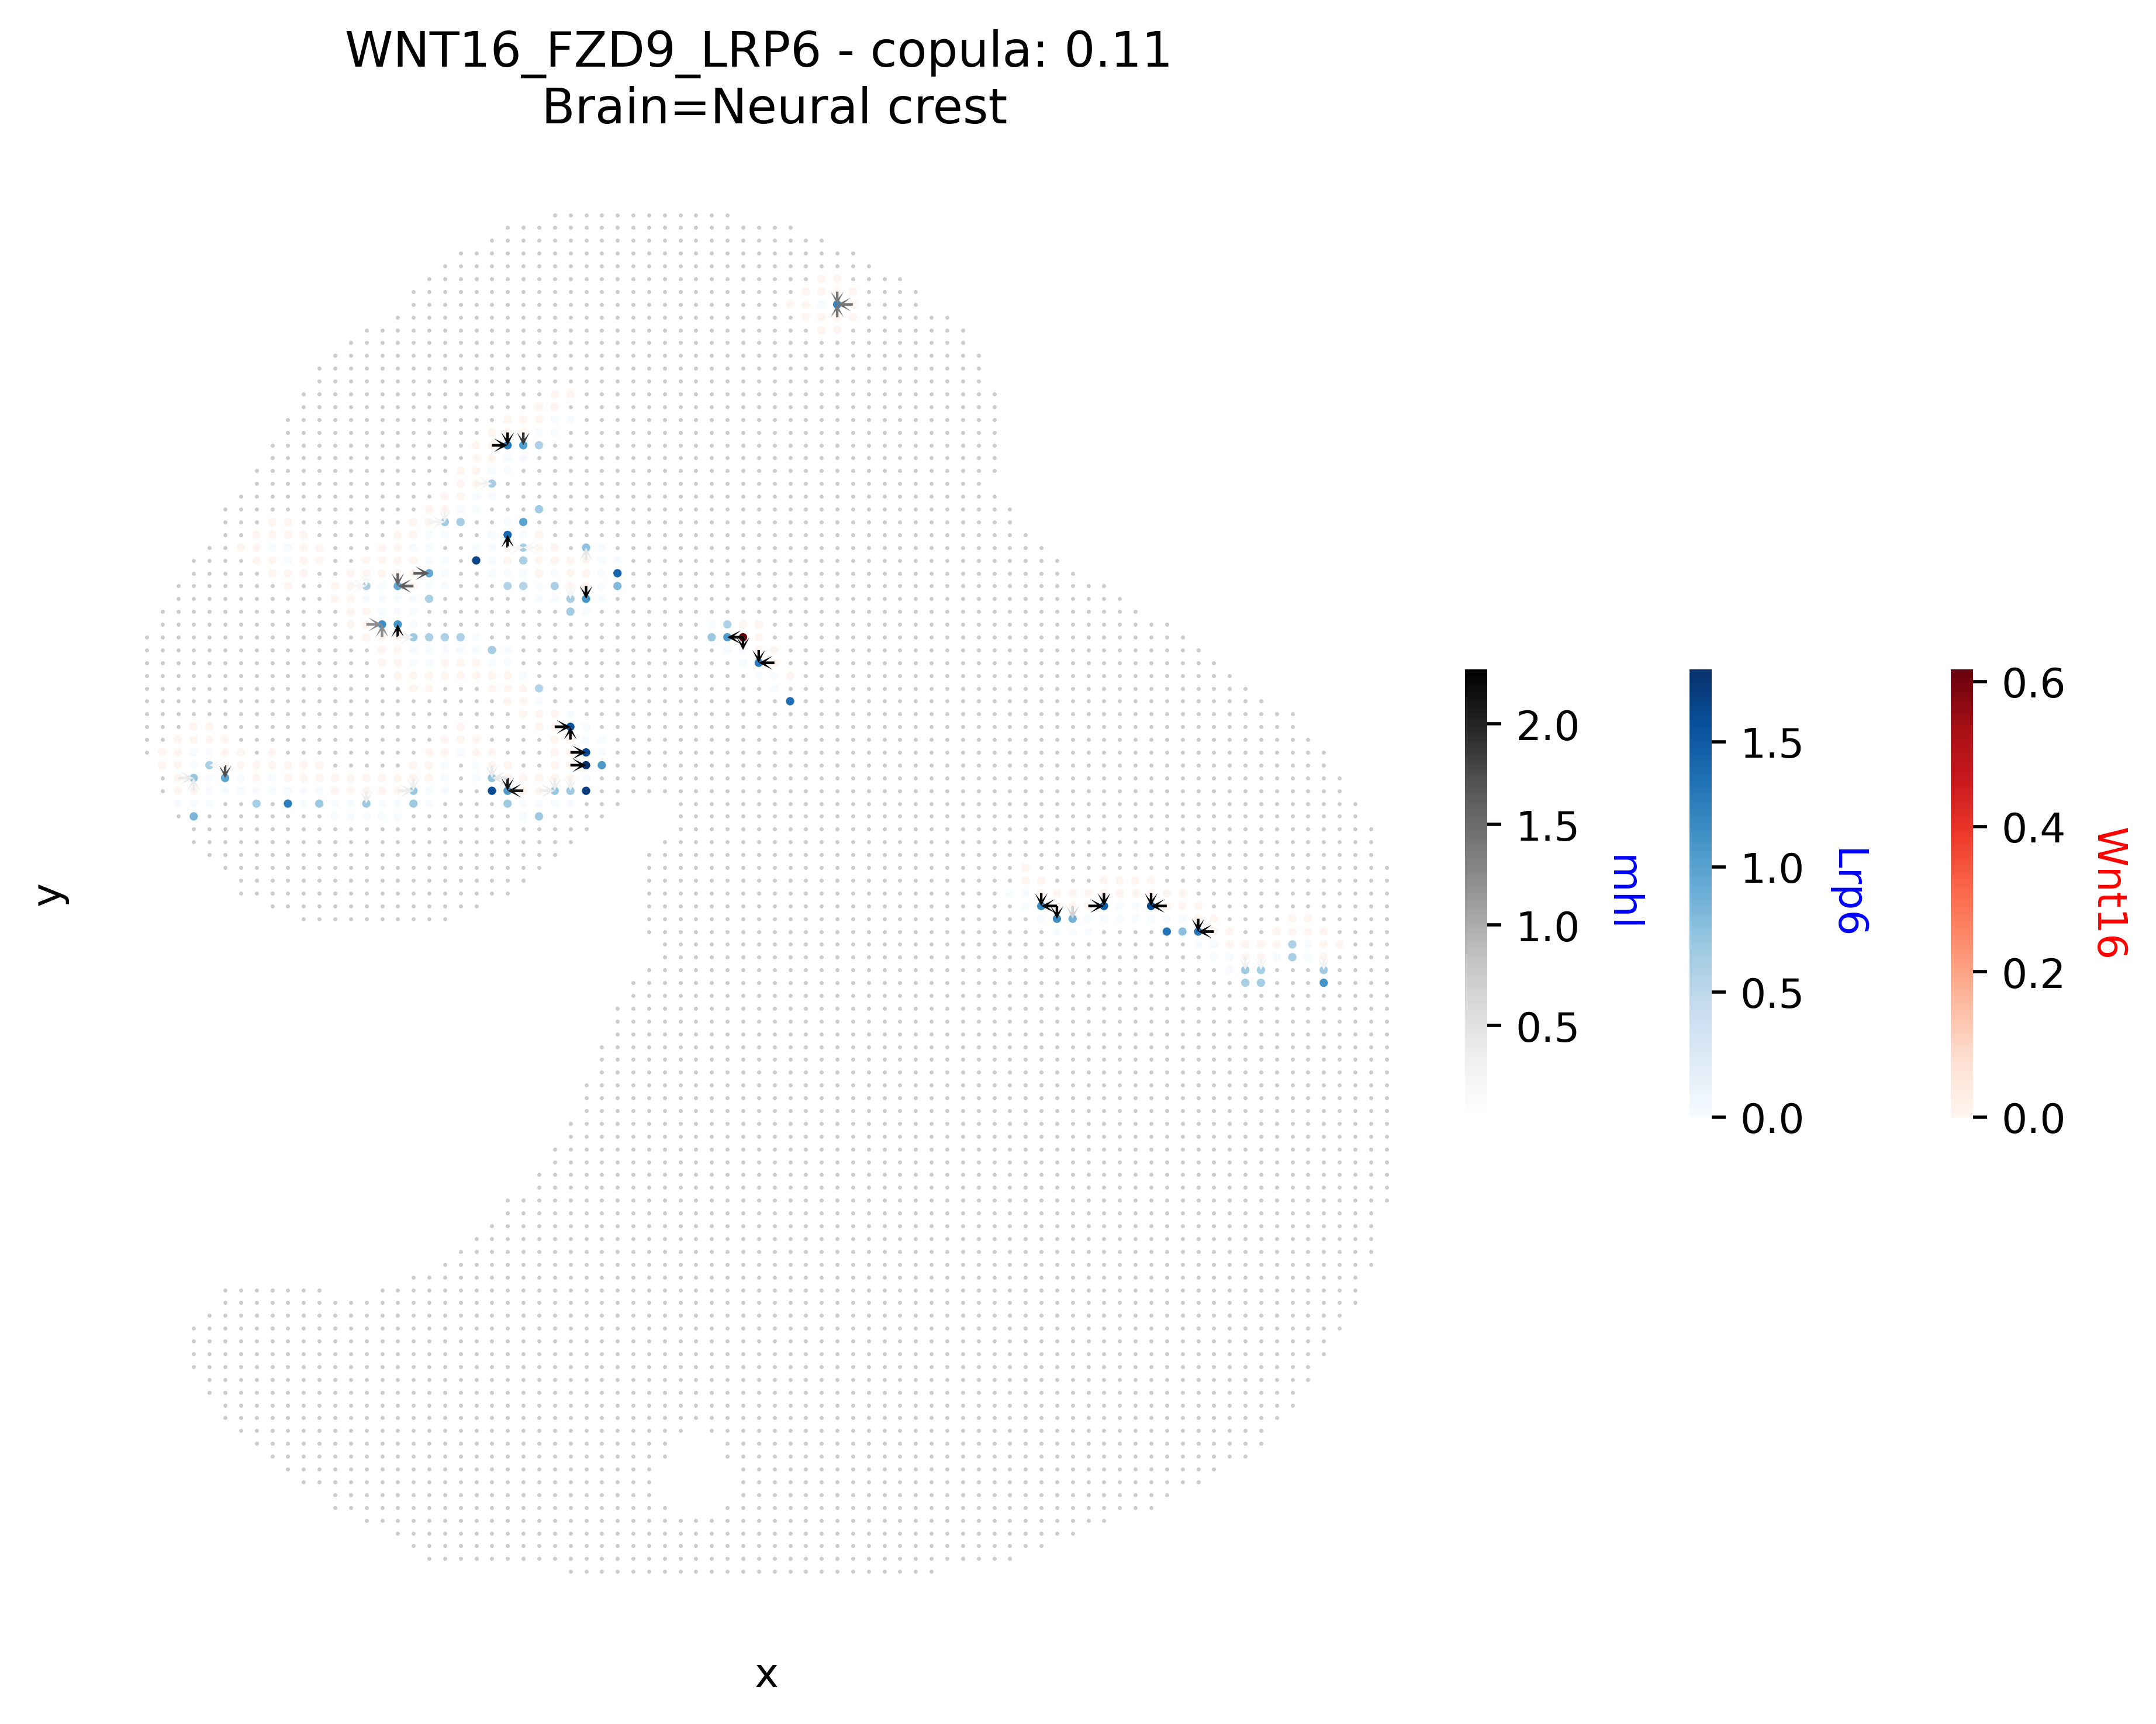

In [452]:
lr_index = 'WNT16_FZD9_LRP6'
gpair = 'Brain=Neural crest'
lr_pairs_ct = plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Wnt16',
    gene2='Lrp6',
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict[gpair],
    shrink_fraction=0.3,
    markersize=5,
    figsize=(8,6),
    figure_parent = figure_parent,
    file_name='MOSTA_{}_two_color.pdf'.format(lr_index)
)

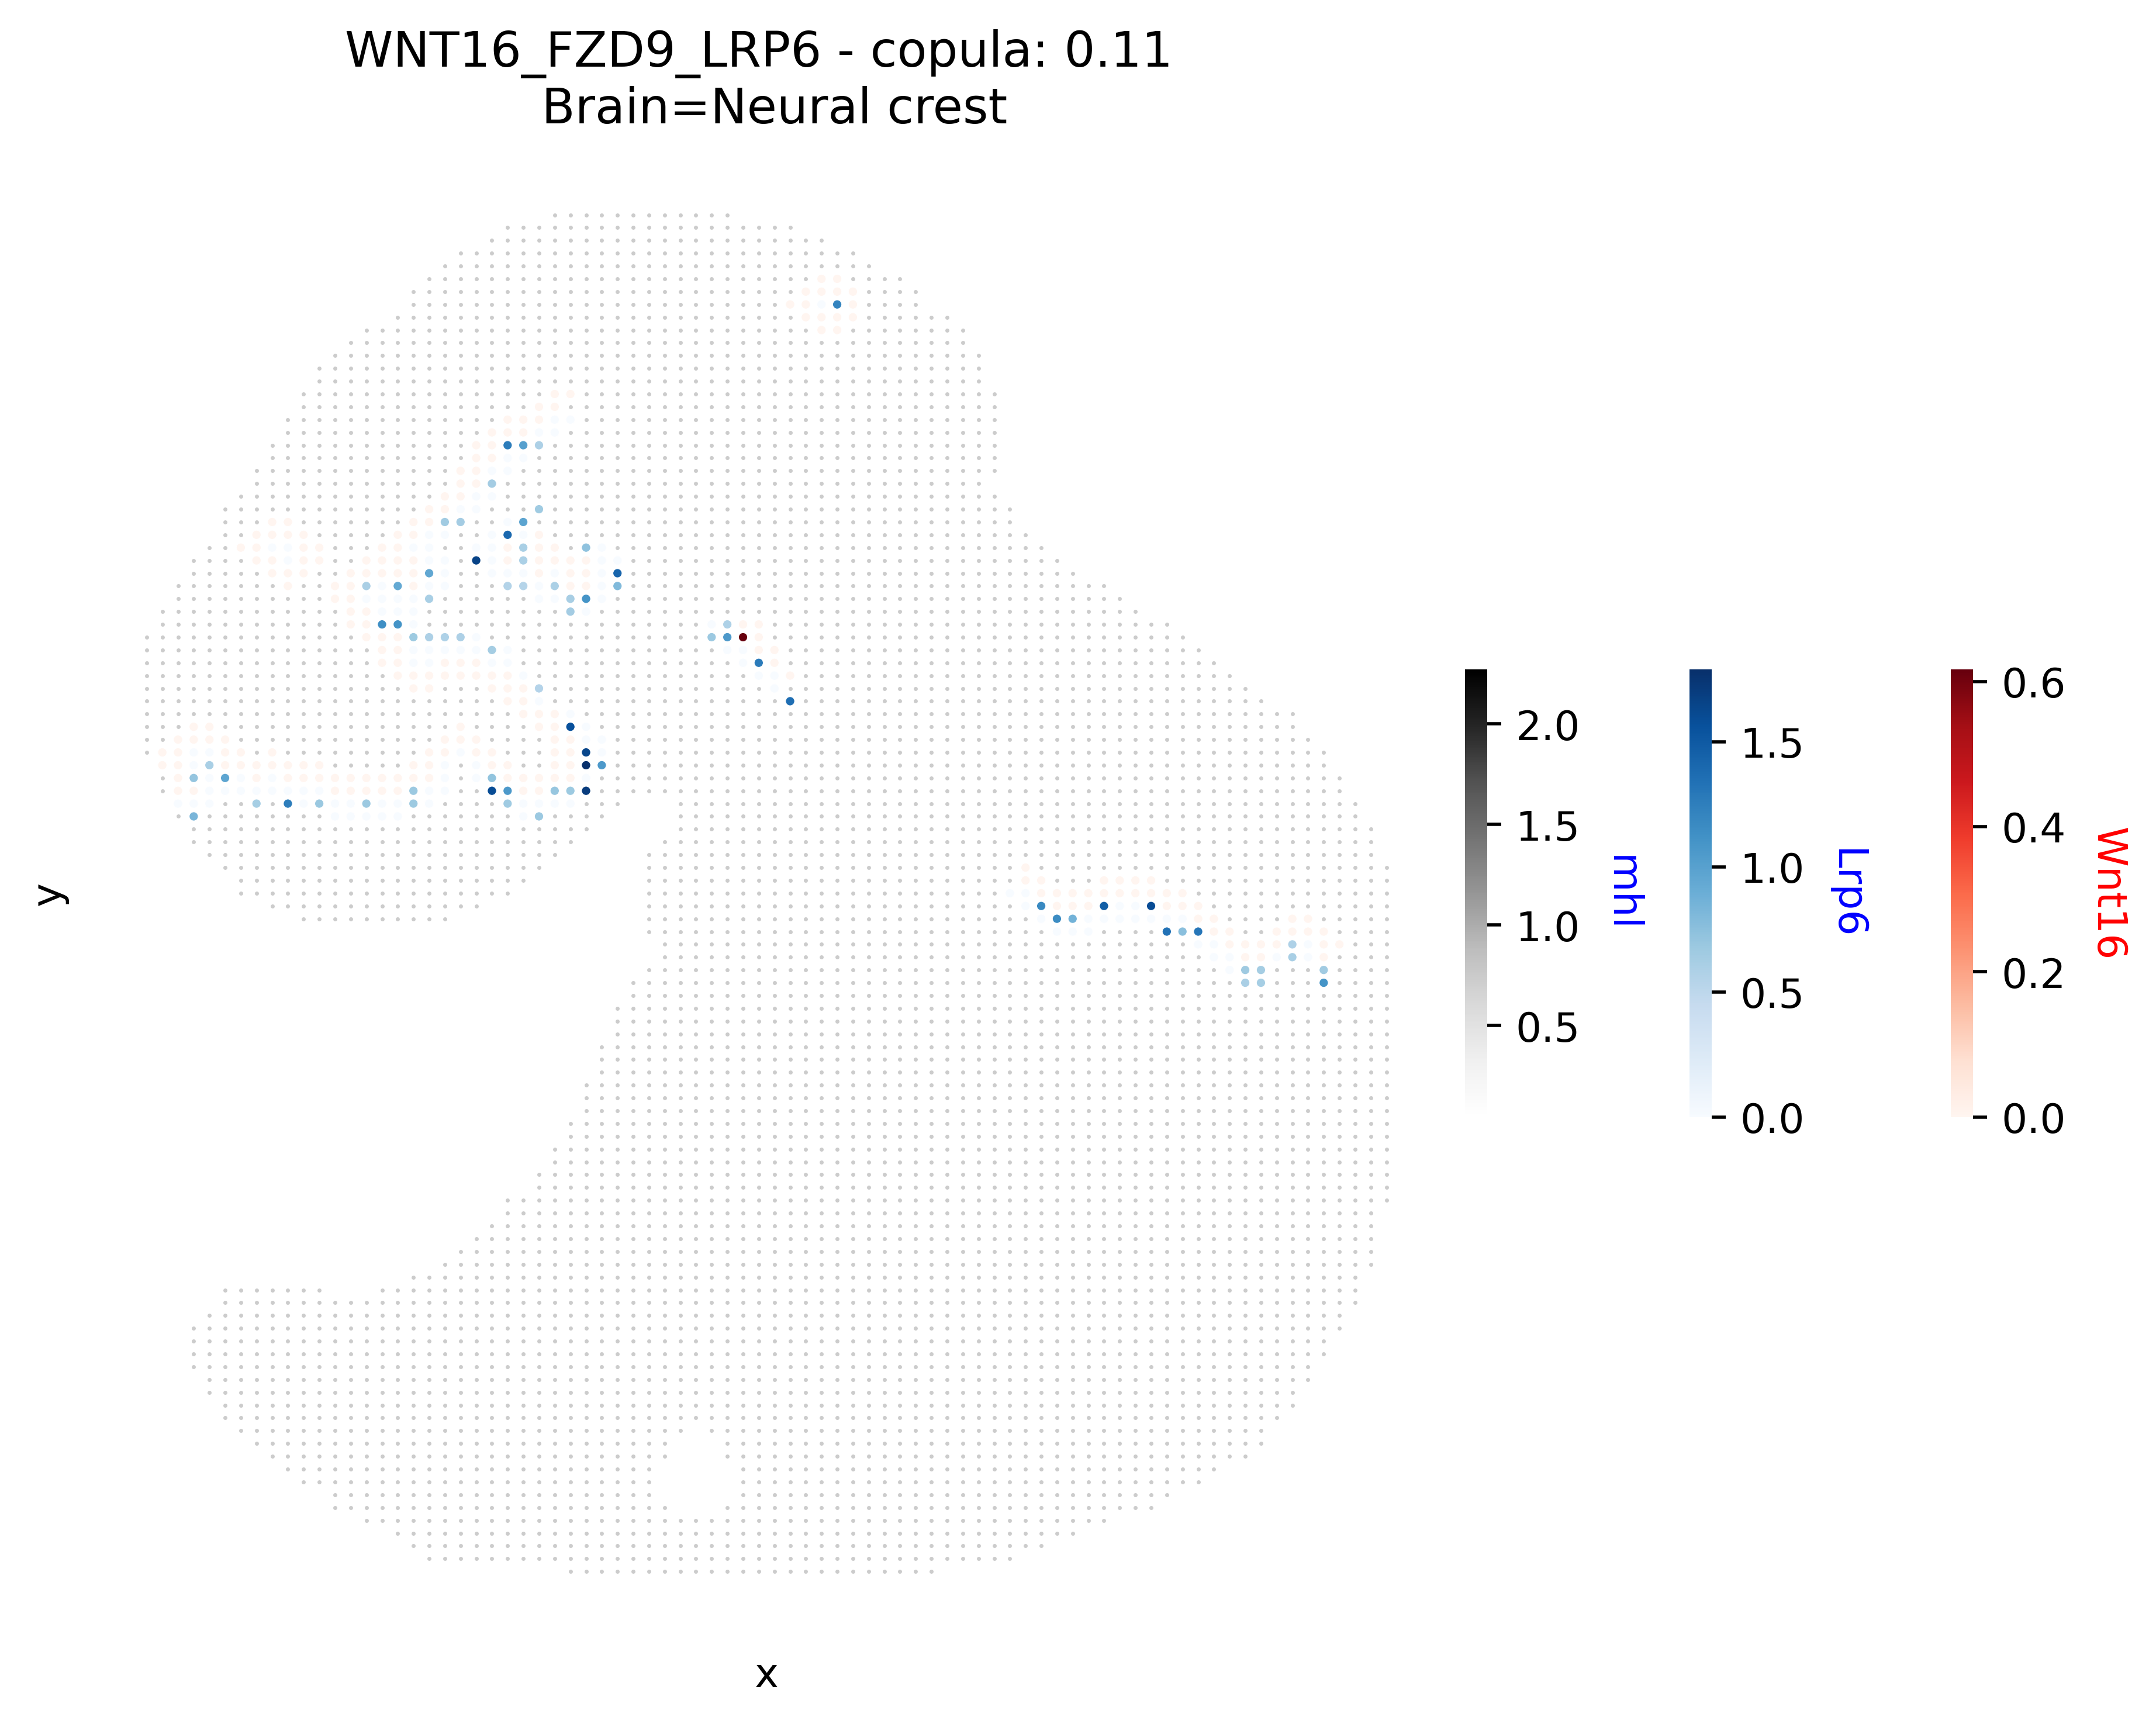

In [531]:
lr_index = 'WNT16_FZD9_LRP6'
gpair = 'Brain=Neural crest'
lr_pairs_ct = plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Wnt16',
    gene2='Lrp6',
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict[gpair],
    shrink_fraction=0.3,
    markersize=5,
    figsize=(8,6),
    figure_parent = figure_parent,
    file_name='MOSTA_{}_two_color.pdf'.format(lr_index)
)

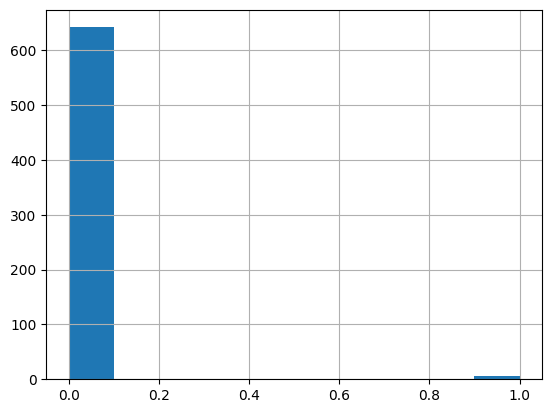

In [456]:
lr_pairs_ct.Wnt16.hist();

In [436]:
lr_index = 'LAMB1_SV2A'
gpair = 'Brain=Neural crest'
merged_res_dict[gpair].loc[lr_index]

copula_coeff        0.337928
mu_x              -10.365903
mu_y              -12.551818
copula_method         copula
copula_pval              0.0
copula_pval_fdr          0.0
scc                 0.111238
scc_pval            0.001996
global_I            0.029621
global_pval              0.0
Name: LAMB1_SV2A, dtype: object

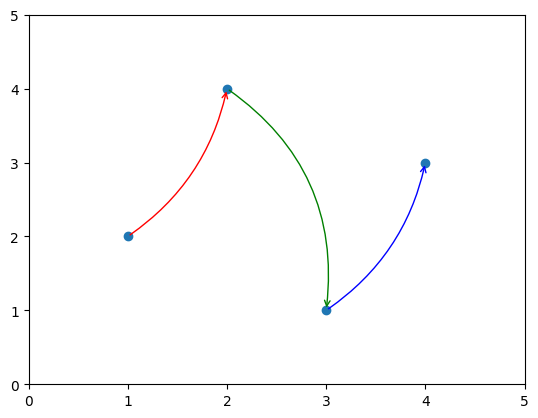

In [262]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Example points
points = [(1, 2), (2, 4), (3, 1), (4, 3)]

# Plotting the points
plt.scatter(*zip(*points))

# Function to add an arrow between two points
def add_curved_arrow(p1, p2, curvature, color):
    """
    Adds a curved arrow between two points.
    p1, p2: The points between which the arrow is to be drawn.
    curvature: Curvature of the arrow. Positive for one direction, negative for the opposite.
    color: Arrow color.
    """
    arrow = FancyArrowPatch(p1, p2, connectionstyle=f"arc3,rad={curvature}", 
                             arrowstyle='->', color=color,
                             mutation_scale=10.0, 
                             lw=1, clip_on=False)
    plt.gca().add_patch(arrow)

# Adding arrows
add_curved_arrow(points[0], points[1], curvature=0.2, color="red")
add_curved_arrow(points[1], points[2], curvature=-0.3, color="green")
add_curved_arrow(points[2], points[3], curvature=0.2, color="blue")

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()


In [198]:
from matplotlib.colors import Normalize
def get_data(lig_rec_pair, gpair, cont_type='other'):
    if cont_type == 'other':
        o = np.array(other_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict[gpair][index][0]
        y = data_list_dict[gpair][index][1]
        us1 = umi_sums[gpair][gpair.split('=')[0]]
        us2 = umi_sums[gpair][gpair.split('=')[1]]
    else:
        o = np.array(close_contact_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict_close[gpair][index][0]
        y = data_list_dict_close[gpair][index][1]
        us1 = umi_sums_selfloop[gpair][gpair.split('=')[0]]
        us2 = umi_sums_selfloop[gpair][gpair.split('=')[1]]
    return (x, y, us1, us2)

def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    genes_to_show,
    shrink_fraction = 1.0,
    both_ways = False,
    only_boundary = False,
    use_raw = True,
    file_name = None,
    markersize=10
):
    if not use_raw:
        count_df = adata_plot.to_df()
    else:
        count_df = adata.to_df()
    g11, g12 = int_type.split('=')
    lr_pairs_ct = None
    if g11 == g12:
            lr_pairs_ct = int_edges_with_selfloop.loc[
                int_edges_with_selfloop.interaction == int_type,
                :
            ].copy()
    else:
        if both_ways:
            if g11 == 'ALL' or g12 == 'ALL':
                if g11 != 'ALL':
                    lr_pairs_ct = int_edges_new.loc[
                    (int_edges_new.celltype2 == g11) | (int_edges_new.celltype2 == g11),
                        :
                    ].copy()
                else:
                    lr_pairs_ct = int_edges_new.loc[
                        (int_edges_new.celltype2 == g12) | (int_edges_new.celltype2 == g12),
                        :
                    ].copy()
                    
                if only_boundary:
                    lr_pairs_ct = lr_pairs_ct.loc[
                        lr_pairs_ct.boundary_type != 'Internal',
                        :
                    ]
                    
        else:
            if g11 == 'ALL':
                lr_pairs_ct = int_edges_new.loc[
                    int_edges_new.celltype2 == g12,
                    :
                ].copy()
            elif g12 == 'ALL':
                lr_pairs_ct = int_edges_new.loc[
                    int_edges_new.celltype1 == g11,
                    :
                ].copy()
            else:
                lr_pairs_ct = int_edges_new.loc[
                    int_edges_new.interaction == int_type,
                    :
                ].copy()
        if lr_pairs_ct is None:
            if g11 == g12:
                lr_pairs_ct = int_edges_with_selfloop.loc[
                    int_edges_with_selfloop.interaction == int_type,
                    :
                ].copy()
            else:
                lr_pairs_ct = int_edges_new.loc[
                        int_edges_new.interaction == int_type,
                        :
                    ].copy()
    #genes_to_show = lig_rec_idx.split("_")
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5),dpi=500)
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.1,alpha = 0.2)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=markersize, 
                        data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax[i],shrink=shrink_fraction)
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        #ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        # ax[i].set_xlabel("spatial1")
        # ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    plt.show()


from sklearn.preprocessing import MinMaxScaler
def lr_interaction_boundary_likelihood(
    gpair, 
    lr_index,filt=True,
    part = False,
    cont_type='other',
    norm=False,
    exp=False,
    mhl = False,
    file_name =None,
    shrink_fraction=1.0
):
    x, y, us1, us2 = get_data(lr_index, gpair, cont_type=cont_type)
    copula_params = model2.CopulaParams()
    copula_params = copula_params._replace(return_sum=False)
    likf = []
    sx = np.log(x.sum() / us1.sum())
    sy = np.log(y.sum() / us2.sum())
    coeff = copulacci_merged_df.loc[
        (copulacci_merged_df.LR_index == lr_index) &
        (copulacci_merged_df.interaction == gpair)
    ].copula_coeff.values[0]


    if mhl:
        # loglikvec = calculate_mahalanobis_distance(
        #     [coeff, sx, sy],
        #     x,
        #     y,
        #     us1,
        #     us2,
        #     copula_params
        # )
        loglikvec = model2.calculate_mahalanobis_distance(
            [coeff, sx, sy],
            x,
            y,
            us1,
            us2,
            copula_params
        )
    else:
        if part:
            loglikvec = log_lik_part(
            [coeff, sx, sy],
                x,
                y,
                us1,
                us2,
                copula_params
            )
        else:    
            loglikvec = model2.log_joint_lik(
                [coeff, sx, sy],
                    x,
                    y,
                    us1,
                    us2,
                    copula_params
                )
    
    #return loglikvec
    loglik_df = pd.DataFrame(np.column_stack([x,y,loglikvec]),
                       columns = ['lig','rec', 'loglik'])
    if gpair.split('=')[0] != gpair.split('=')[1]:
        lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == gpair,
        :
        ].copy()
    else:
        if cont_type == 'other':
            lr_pairs_ct = int_edges_with_selfloop.loc[
            (int_edges_with_selfloop.interaction == gpair),
            :
            ].copy()
        else:
            lr_pairs_ct = int_edges_with_selfloop.loc[
            (int_edges_with_selfloop.interaction == gpair) & (int_edges_with_selfloop.self_loop == True),
            :
            ].copy()
        
    loglik_df.loc[:, 'cell1'] = lr_pairs_ct.cell1.values
    loglik_df.loc[:, 'cell2'] = lr_pairs_ct.cell2.values

    if filt:
        loglik_df_filt = loglik_df.loc[loglik_df.lig + loglik_df.rec > 0].copy()
    else:
        loglik_df_filt = loglik_df
        
    scaler = MinMaxScaler()
    if exp:
        loglik_df_filt['loglik'] = np.exp(loglik_df_filt['loglik'])
    if norm:
        loglik_df_filt['copula_score'] =  (loglik_df_filt['loglik'] - loglik_df_filt['loglik'].min()) \
            / (loglik_df_filt['loglik'].max() - loglik_df_filt['loglik'].min())
    else:
        loglik_df_filt['copula_score'] = loglik_df_filt['loglik']
    
    
    
    fig, ax = plt.subplots(figsize=(5,5),dpi=500)
    cmap = plt.get_cmap('Reds')
    norm = Normalize(vmin=min(loglik_df_filt.copula_score),
                     vmax=np.quantile(loglik_df_filt.copula_score,0.9)
                    )

    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    loglik = loglik_df_filt.loglik
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.1);
    for spine in ax.spines.values():
        spine.set_visible(False)
    for ind,row in loglik_df_filt.iterrows():
        color = cmap(norm(row.copula_score))
        x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
        x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
        ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
                linestyle='-', markersize=0.5,linewidth=1)
    if mhl:
        cbar = plt.colorbar(sm, ax=ax, label='Mahalanobis distance', shrink=shrink_fraction)
        cbar.outline.set_visible(False)
    else:
        cbar = plt.colorbar(sm, ax=ax, label='Copula Score', shrink=shrink_fraction)
    
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    return loglik_df_filt

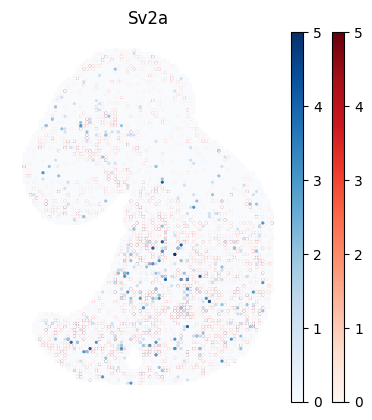

In [523]:
ax = sc.pl.spatial(
    adata,
    cmap='Reds',
    color = ['Lamb1'],
    spot_size=1,
    vmax=5,
    frameon=False,
    show=False
)
ax = sc.pl.spatial(
    adata,
    cmap='Blues',
    color = ['Sv2a'],
    spot_size=1,
    #frameon=False,
    show=False,
    ax=ax[0]
)
plt.gca().invert_yaxis()

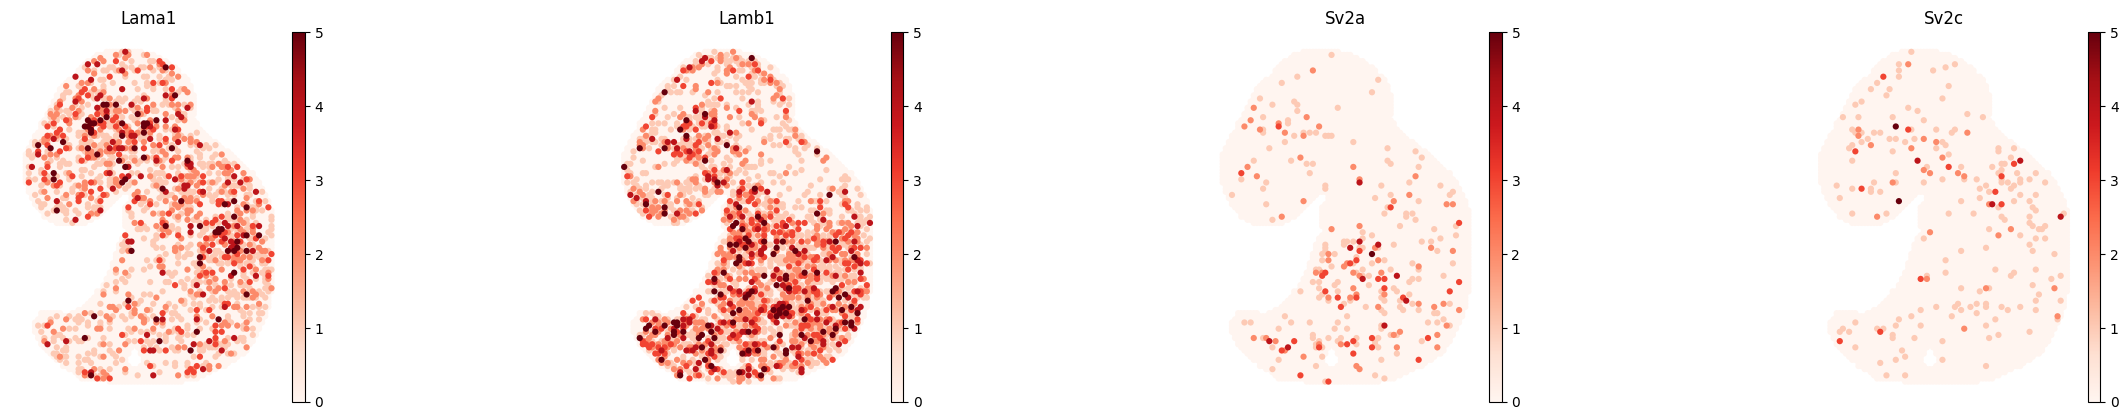

In [530]:
sc.pl.spatial(
    adata,
    cmap='Reds',
    color = ['Lama1','Lamb1','Sv2a','Sv2c'],
    spot_size=2,
    vmax=5,
    frameon=False,
)

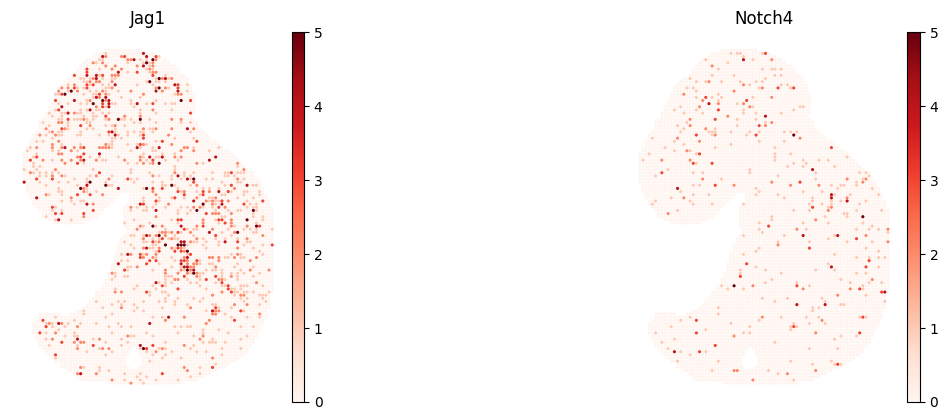

In [529]:
sc.pl.spatial(
    adata,
    cmap='Reds',
    color = ['Jag1', 'Notch4'],
    spot_size=1,
    vmax=5,
    frameon=False,
)

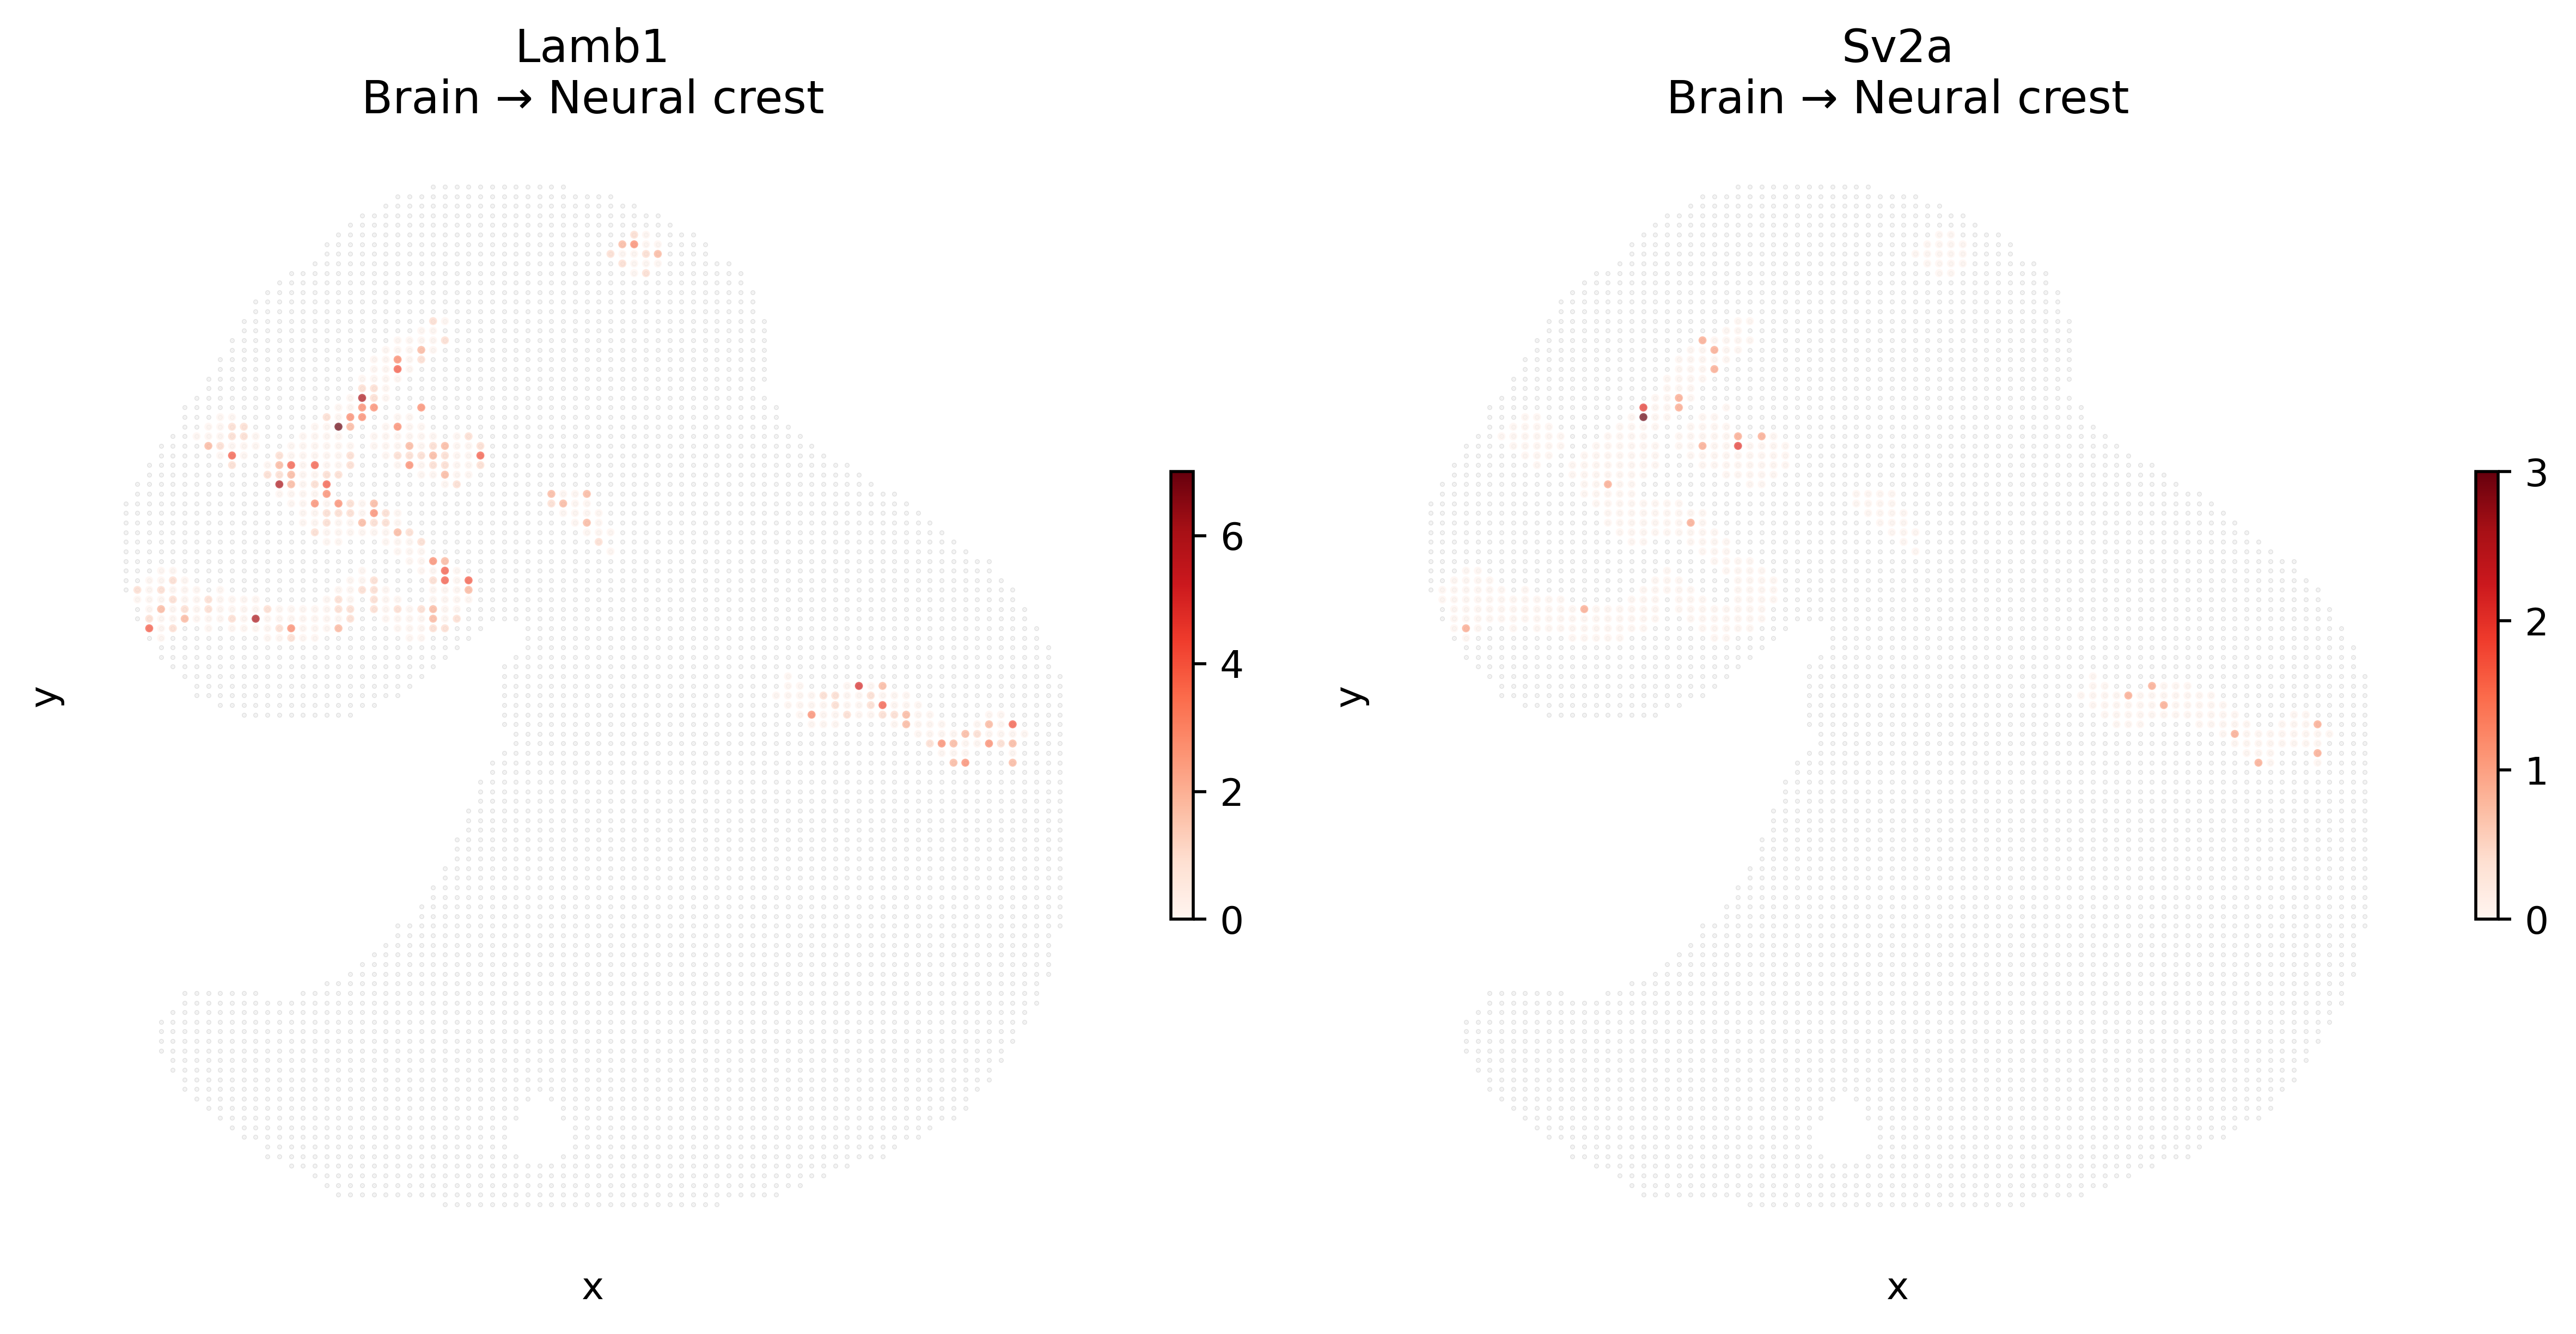

In [444]:
lr_index = 'LAMB1_SV2A'
gpair =  'Brain=Neural crest'
plot_raw_lr_boundary_expression(
    lr_index,
    gpair,
    loc_df,
    int_edges_new,
    genes_to_show = ['Lamb1', 'Sv2a'],
    shrink_fraction = 0.4,
    both_ways=False,
    only_boundary=True,
    use_raw=True,
    markersize=5
    #file_name = 'BRCA_il6_cd4_tumor.pdf'
)

In [189]:
[l.title() for l in lr_index.split('_')]

['Lamb1', 'Sv2A']

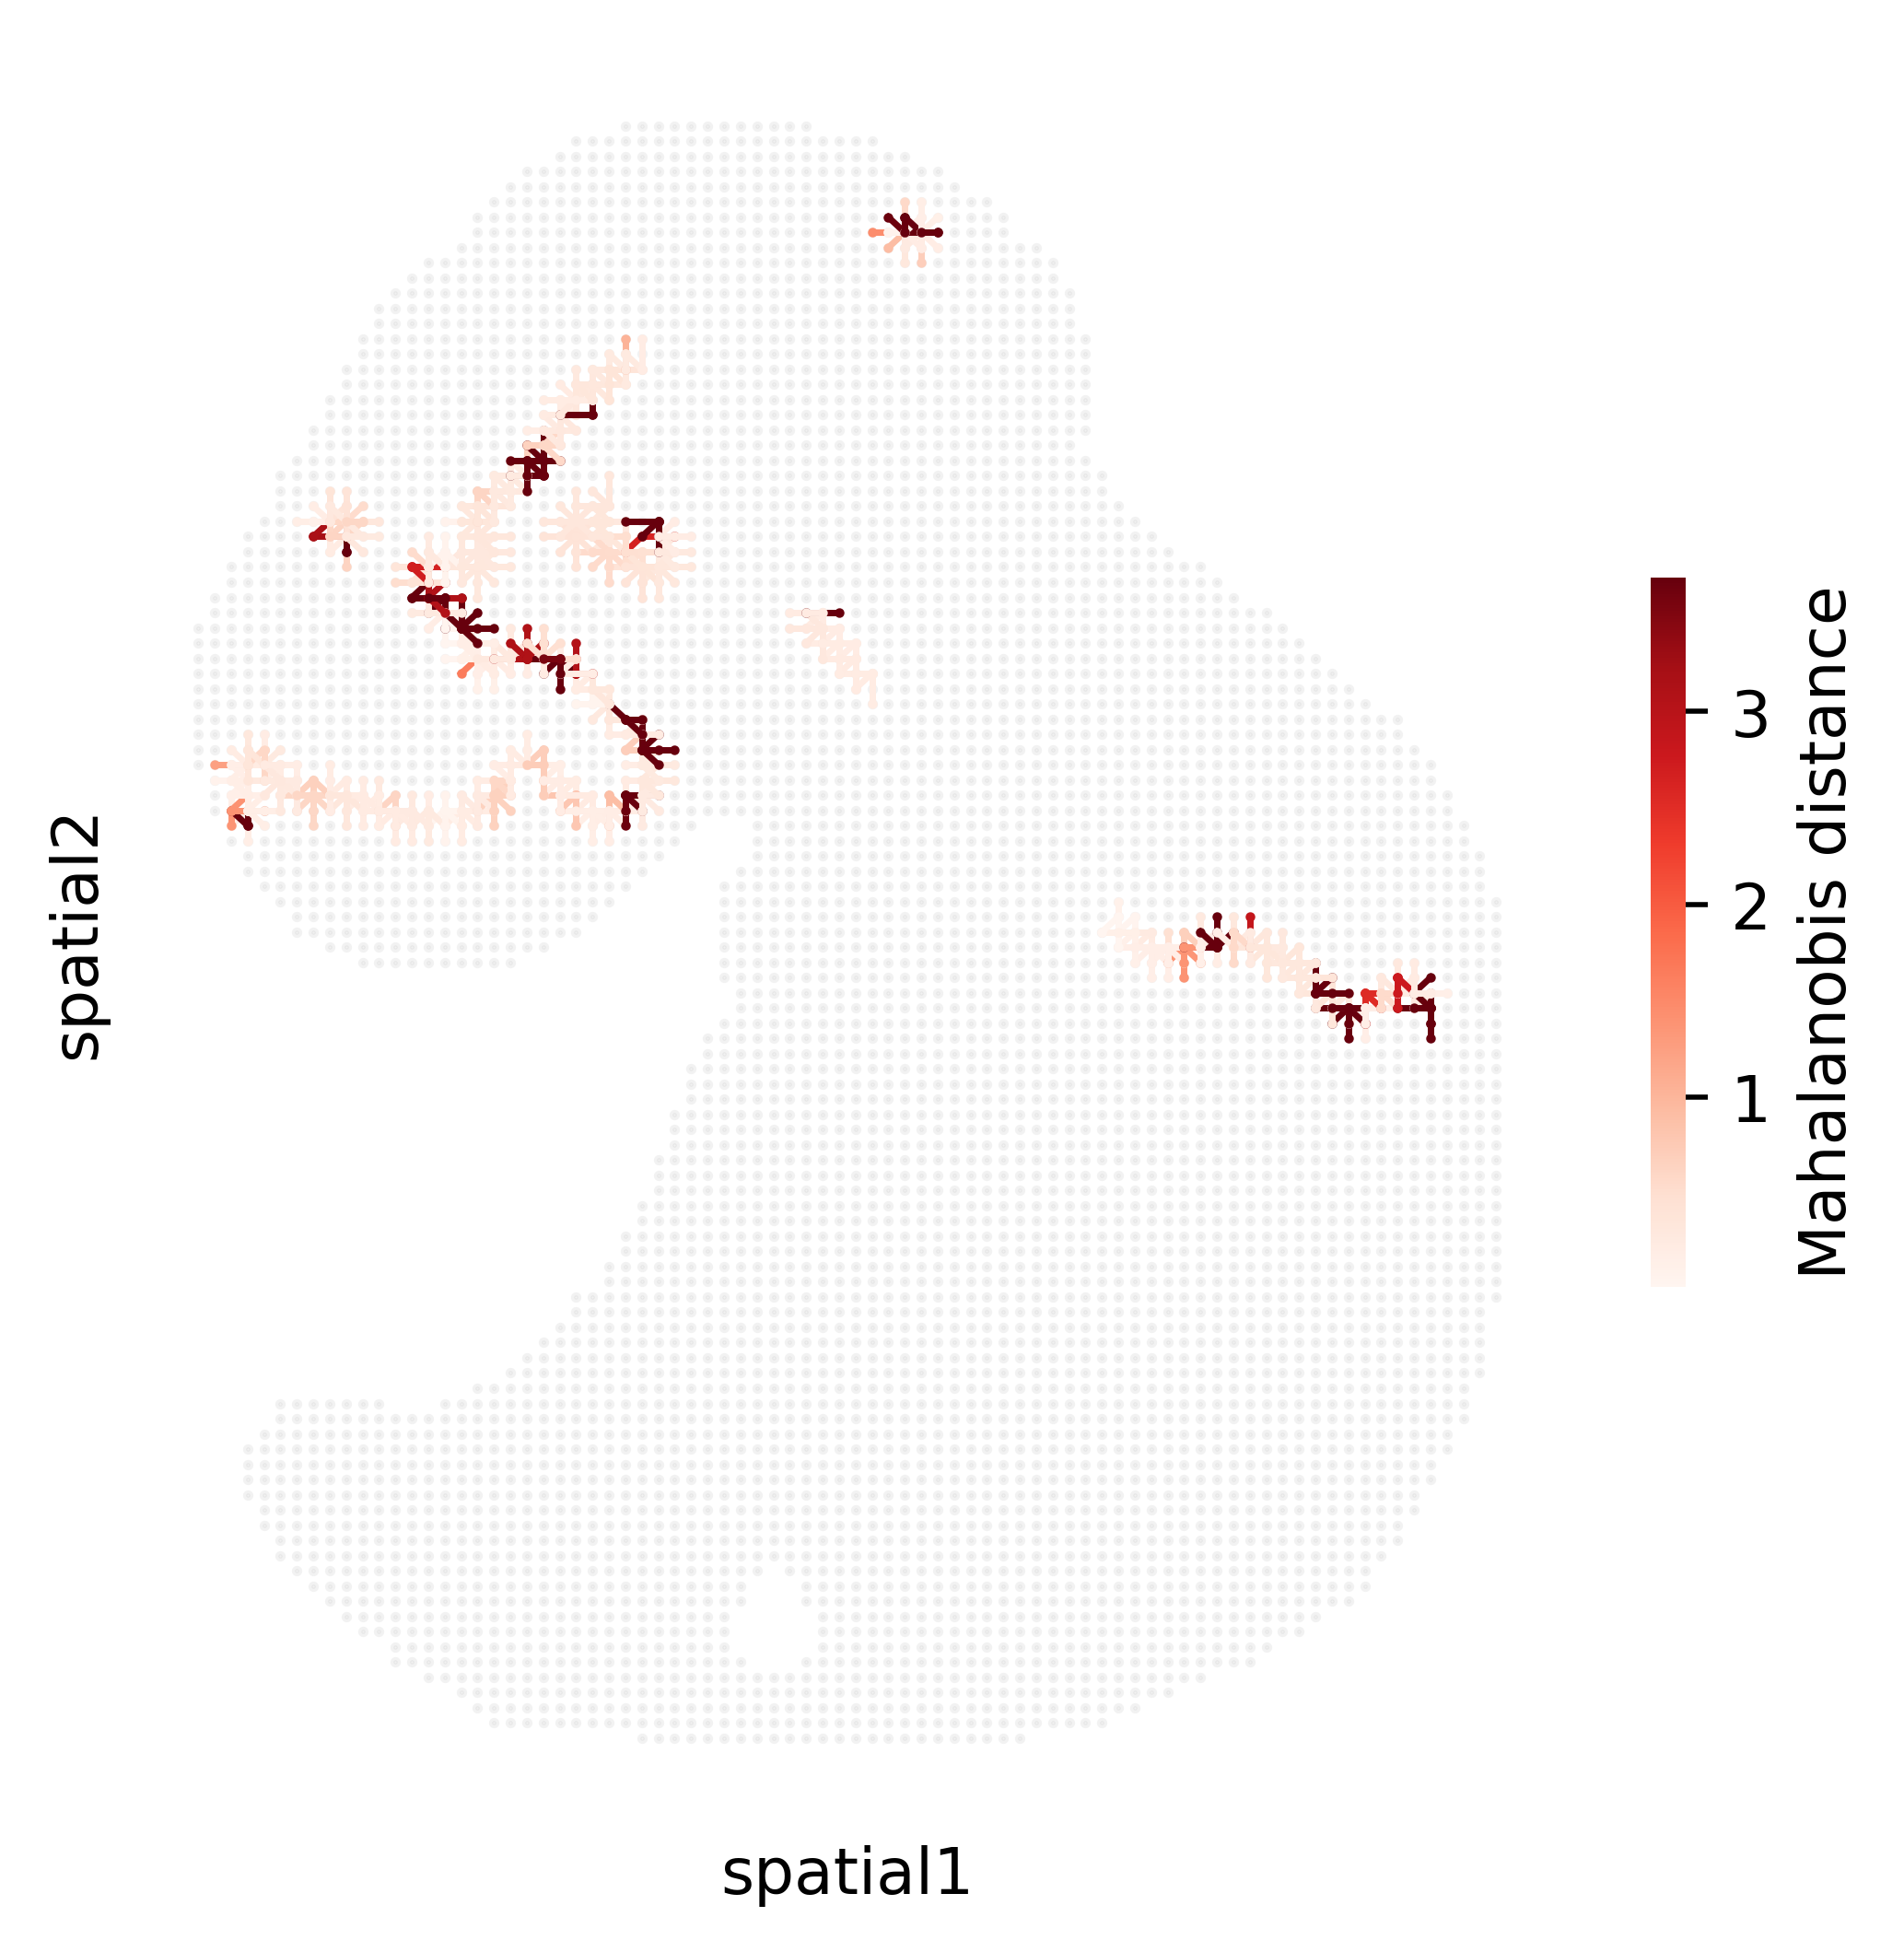

In [199]:
lr_index = 'LAMB1_SV2A'
gpair = 'Brain=Neural crest'
loglik_df = lr_interaction_boundary_likelihood(gpair, lr_index,
            filt=False,part=False,cont_type='other',norm=False,exp=False,mhl=True,
            shrink_fraction=0.4,
#            file_name='BRCA_il6_cd4_tumor_mhl_score.pdf'
)

In [161]:
import matplotlib

In [162]:
matplotlib.__version__

'3.8.3'

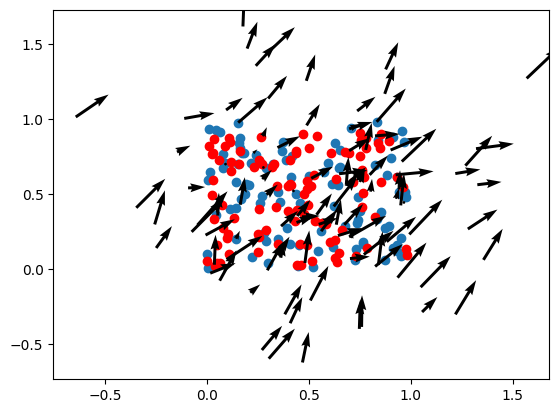

In [167]:
import numpy as np
import matplotlib.pyplot as plt

def bend_quiver(X, Y, U, V, threshold=0.1):
  """Bends the arrows in a quiver plot so that they do not overlap.

  Args:
    X: The x-coordinates of the points.
    Y: The y-coordinates of the points.
    U: The x-components of the vectors.
    V: The y-components of the vectors.
    threshold: The minimum distance between two points for their arrows to be bent.

  Returns:
    A tuple of two arrays, (X_new, Y_new), where X_new and Y_new are the
    x- and y-coordinates of the bent arrows.
  """

  # Calculate the distance between each point and its neighbors.
  distances = np.sqrt((X[:, np.newaxis] - X) ** 2 + (Y[:, np.newaxis] - Y) ** 2)

  # Find the indices of the neighbors that are closer than the threshold.
  neighbors = np.where(distances < threshold)

  # Bend the arrows that are close to their neighbors.
  X_new = X.copy()
  Y_new = Y.copy()
  for i, j in zip(neighbors[0], neighbors[1]):
    if i != j:
      X_new[i], Y_new[i] = bend_arrow(X[i], Y[i], U[i], V[i], X[j], Y[j])

  return X_new, Y_new

def bend_arrow(x1, y1, u1, v1, x2, y2):
  """Bends an arrow so that it does not overlap with another arrow.

  Args:
    x1: The x-coordinate of the start of the arrow.
    y1: The y-coordinate of the start of the arrow.
    u1: The x-component of the vector.
    v1: The y-component of the vector.
    x2: The x-coordinate of the end of the arrow.
    y2: The y-coordinate of the end of the arrow.

  Returns:
    A tuple of two floats, (x_new, y_new), where x_new and y_new are the
    x- and y-coordinates of the bent arrow.
  """

  # Calculate the angle between the two arrows.
  angle = np.arctan2(v1, u1) - np.arctan2(y2 - y1, x2 - x1)

  # Bend the arrow by a small amount.
  x_new = x1 + u1 * np.cos(angle + 0.1)
  y_new = y1 + v1 * np.sin(angle + 0.1)

  return x_new, y_new

# Example usage:

X = np.random.rand(100)
Y = np.random.rand(100)
U = np.random.rand(100)
V = np.random.rand(100)

plt.scatter(X,Y)
plt.scatter(U,V,c='red')
X_new, Y_new = bend_quiver(X, Y, U, V)

plt.quiver(X_new, Y_new, U, V)
plt.show()